In [1]:
import os
import wx
app = wx.App()
backend = __import__("Integration")
t1 = backend.turtle_setup()
home = (0,0)

In [2]:
class TabOne(wx.Panel):
    def __init__(self, parent):
        wx.Panel.__init__(self, parent)
        
        img = wx.Image(500, 500)
        self.imageCtrl = wx.StaticBitmap(self, wx.ID_ANY, wx.Bitmap(img))
        
class TabTwo(wx.Panel):
    def __init__(self, parent):
        wx.Panel.__init__(self, parent)
        self.GCODE = wx.TextCtrl(self, style = wx.TE_READONLY | wx.TE_MULTILINE)
        
        bsizer = wx.BoxSizer()
        bsizer.Add(self.GCODE, 1, wx.EXPAND)
        
        self.SetSizerAndFit(bsizer)

In [3]:
class MainPanel(wx.Panel):
    def __init__(self, parent):
        wx.Panel.__init__(self, parent)
        
        subSizer = wx.BoxSizer(wx.VERTICAL)
        grid = wx.GridBagSizer(hgap=5, vgap=5)
        
        self.filepath = wx.TextCtrl(self, value="Filename", size=(500,-1), style = wx.TE_READONLY)

        self.btnOpen =wx.Button(self, label="Open")
        self.Bind(wx.EVT_BUTTON, self.OnOpen, self.btnOpen)
        
        self.btnCalibrate =wx.Button(self, label="Calibrate")
        self.Bind(wx.EVT_BUTTON, self.OnCalibrate, self.btnCalibrate)
        
        self.btnPrint =wx.Button(self, label="Print Image")
        self.Bind(wx.EVT_BUTTON, self.OnPrint, self.btnPrint)
        
        self.nb = wx.Notebook(self)
        
        self.tab1 = TabOne(self.nb)
        self.tab2 = TabTwo(self.nb)
        
        self.nb.AddPage(self.tab1, "Image Preview")
        self.nb.AddPage(self.tab2, "GCODE")
        
        grid.Add(self.btnOpen, pos=(0,0))
        grid.Add(self.btnCalibrate, pos=(0,1))
        grid.Add(self.btnPrint, pos=(0,2))
        grid.Add(self.filepath, pos=(1,0), span=(0,5))
        grid.Add(self.nb, pos=(2,0), span=(5,5))
        subSizer.Add(grid, 0, wx.ALL, 5)
        self.SetSizerAndFit(subSizer)
        
        self.calibrated = False
        
    def OnOpen(self,e):
        """ Open a file"""
        self.dirname = ''
        self.filename = ''
        self.file_extension = ''
        wildcard = "DXF files (*.dxf)|*.dxf|JPEG and PNG files (*.jpg;*.png)|*.jpg;*.png"
        dlg = wx.FileDialog(self, "Choose a file", self.dirname, "", wildcard, wx.FD_OPEN)
        if dlg.ShowModal() == wx.ID_OK:
            self.filename = dlg.GetFilename()
            self.dirname = dlg.GetDirectory()
            self.path = self.dirname + "\\" + self.filename
            self.filepath.SetValue(self.dirname + "\\" + self.filename)
            self.file_extension = os.path.splitext(self.path)[1]
            if self.file_extension.lower() == ".png" or self.file_extension.lower() == ".jpg":
                self.PreviewImage(self, self.path)
                backend.png_generate_gcode(self.path, 0.7, "output.gcode")
                generated = True
            elif self.file_extension.lower() == ".dxf":
                print(self.path)
                self.PreviewDXF(self, self.path)
                backend.dxf_generate_gcode(self.path, "output.gcode")
                generated = True
            else:
                print(self.file_extension)
            if generated == True:
                self.PreviewGCODE(self)
        dlg.Destroy()
        
    def PreviewImage(self, e, path):
        filename, file_extension = os.path.splitext(path)
        img_size = 500
        img = wx.Image(path, wx.BITMAP_TYPE_ANY)
        W = img.GetWidth()
        H = img.GetHeight()
        if W > H:
            NewW = img_size
            NewH = img_size * H / W
        else:
            NewH = img_size
            NewW = img_size * W / H
        img = img.Scale(NewW,NewH)
        self.tab1.imageCtrl.SetBitmap(wx.Bitmap(img))
        self.Refresh()
    
    def PreviewDXF(self, e, path):
        backend.view_dxf(path)
        img_size = 500
        img = wx.Image('Images/Outputs/dxf_output.png', wx.BITMAP_TYPE_ANY)
        W = img.GetWidth()
        H = img.GetHeight()
        if W > H:
            NewW = img_size
            NewH = img_size * H / W
        else:
            NewH = img_size
            NewW = img_size * W / H
        img = img.Scale(NewW,NewH)
        self.tab1.imageCtrl.SetBitmap(wx.Bitmap(img))
        self.Refresh()
        
    def PreviewGCODE(self, e):
        fileGCODE = open("output.gcode", 'r') 
        Lines = fileGCODE.readlines()
        string_lines = ""
        for line in Lines:
            string_lines = string_lines + line
        self.tab2.GCODE.WriteText(string_lines)
        
    def OnCalibrate(self, e):
        dlg = wx.MessageDialog(self, "Are you sure you want to calibrate the simulation home position?",'Calibrate?',wx.YES_NO | wx.ICON_QUESTION)
        result = dlg.ShowModal()
        if result == wx.ID_YES:
            frame = CalibrationWindow(None, "Calibrate")
            parent=wx.GetTopLevelParent(self)
            parent.Show(False)
            frame.SetFocus()
            frame.Raise()
        else:
            print("No pressed")
            
    def OnPrint(self, e):
        t1 = backend.open_sim("Click to close when simulation finishes.")
        backend.draw_output(t1, "output.gcode", 1)
        

In [4]:
class MainWindow(wx.Frame):

    def __init__(self, parent, title):
        self.dirname=''
        
        self.frame = wx.Frame.__init__(self, parent, title=title, size=(500,-1))
        self.CreateStatusBar()
        panel = MainPanel(self)
        
        filemenu= wx.Menu()
        menuOpen = filemenu.Append(wx.ID_OPEN, "&Open"," Open a file")
        menuAbout = filemenu.Append(wx.ID_ABOUT, "&About"," Information about this program")
        menuExit = filemenu.Append(wx.ID_EXIT,"E&xit"," Terminate the program")
        
        menuBar = wx.MenuBar()
        menuBar.Append(filemenu,"&File")
        self.SetMenuBar(menuBar)
        
        self.Bind(wx.EVT_MENU, self.OnOpen, menuOpen)
        self.Bind(wx.EVT_MENU, self.OnAbout, menuAbout)
        self.Bind(wx.EVT_MENU, self.OnExit, menuExit)
        
        mainSizer = wx.BoxSizer(wx.VERTICAL)
        mainSizer.Add(panel)
        self.SetSizerAndFit(mainSizer)
        self.Show(True)
    
    def OnOpen(self,e):
        self.dirname = ''
        self.filename = ''
        wildcard = "JPEG and PNG files (*.jpg;*.png)|*.jpg;*.png|DXF files (*.dxf)|*.dxf"
        dlg = wx.FileDialog(self, "Choose a file", self.dirname, "", wildcard, wx.FD_OPEN)
        if dlg.ShowModal() == wx.ID_OK:
            self.filename = dlg.GetFilename()
            self.dirname = dlg.GetDirectory()
            self.path = self.dirname + "\\" + self.filename
            self.filepath.SetValue(self.dirname + "\\" + self.filename)
            self.PreviewImage(self, self.path)
        dlg.Destroy()
        
    def OnAbout(self,e):
        dlg = wx.MessageDialog( self, "This program was created as an MSc dissertation. " +
                            "It can convert PNG, JPEG & DXF files into GCODE and then create a 2D print from the GCODE.")
        dlg.ShowModal()
        dlg.Destroy()

    def OnExit(self,e):
        self.Close(True)  # Close the frame.

In [5]:
class CalibrationPanel(wx.Panel):
    def __init__(self, parent):
        self.t1 = backend.open_sim("Calibrate")
        global home
        backend.move_turtle(self.t1, home[0], home[1], 1)
        
        wx.Panel.__init__(self, parent)

        subSizer = wx.BoxSizer(wx.VERTICAL)
        grid = wx.GridBagSizer(hgap=5, vgap=5)
        
        self.lblX = wx.StaticText(self, wx.ID_ANY, label="Home x value:", style=wx.ALIGN_CENTER)
        self.txtXCoord = wx.TextCtrl(self, value=str(home[0]), size=(100,-1))
        
        self.lblY = wx.StaticText(self, wx.ID_ANY, label="Home Y value:", style=wx.ALIGN_CENTER)
        self.txtYCoord = wx.TextCtrl(self, value=str(home[1]), size=(100,-1))
        
        self.btnCalibrate =wx.Button(self, label="Set home")
        self.Bind(wx.EVT_BUTTON, self.OnCalibrate, self.btnCalibrate)
        
        self.btnExit =wx.Button(self, label="Done")
        self.Bind(wx.EVT_BUTTON, self.OnExit, self.btnExit)
        
        grid.Add(self.lblX, pos=(0,0))
        grid.Add(self.txtXCoord, pos=(0,1))
        grid.Add(self.lblY, pos=(0,2))
        grid.Add(self.txtYCoord, pos=(0,3))
        grid.Add(self.btnCalibrate, pos=(1,1))
        grid.Add(self.btnExit, pos=(1,3))
        subSizer.Add(grid, 0, wx.ALL, 5)
        self.SetSizerAndFit(subSizer)
        
        
    def OnCalibrate(self,e):
        xCoord = int(self.txtXCoord.GetValue())
        yCoord = int(self.txtYCoord.GetValue())
        backend.calibrate_sim(self.t1, xCoord, yCoord)
        global home
        home = (xCoord,yCoord)
        
    def OnExit(self,e):
        dlg = wx.MessageDialog(self, "Any changes since confirming calibration by pressing 'Set Home' will be lost. \n" + 
                               "Are you sure you're done calibrating the simulation home position?",
                               'Calibrated?',wx.YES_NO | wx.ICON_QUESTION)
        result = dlg.ShowModal()
        if result == wx.ID_YES:
            backend.close_sim(self.t1)
            mainFrame.Show(True)
            parent=wx.GetTopLevelParent(self)
            parent.Close(True)  # Close the frame.
        else:
            print("No pressed")

In [6]:
class CalibrationWindow(wx.Frame):

    def __init__(self, parent, title):
        self.dirname=''
        
        self.frame = wx.Frame.__init__(self, parent, title=title, size=(500,-1), style=wx.CAPTION)
        self.CreateStatusBar()
        panel = CalibrationPanel(self)
        
        mainSizer = wx.BoxSizer(wx.VERTICAL)
        mainSizer.Add(panel)
        self.SetSizerAndFit(mainSizer)
        self.Show(True)

225
225


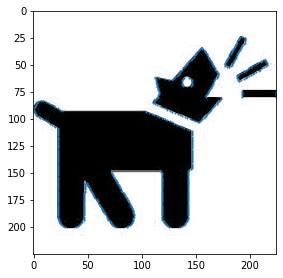

G00 X29 Y24
G01 X39 Y24
G00 X76 Y24
G01 X86 Y24
G00 X125 Y24
G01 X135 Y24
G00 X27 Y25
G01 X41 Y25
G00 X74 Y25
G01 X87 Y25
G00 X124 Y25
G01 X137 Y25
G00 X26 Y26
G01 X42 Y26
G00 X73 Y26
G01 X89 Y26
G00 X123 Y26
G01 X139 Y26
G00 X25 Y27
G01 X43 Y27
G00 X72 Y27
G01 X90 Y27
G00 X122 Y27
G01 X140 Y27
G00 X24 Y28
G01 X44 Y28
G00 X71 Y28
G01 X91 Y28
G00 X121 Y28
G01 X140 Y28
G00 X24 Y29
G01 X45 Y29
G00 X71 Y29
G01 X91 Y29
G00 X120 Y29
G01 X141 Y29
G00 X23 Y30
G01 X45 Y30
G00 X70 Y30
G01 X92 Y30
G00 X120 Y30
G01 X142 Y30
G00 X23 Y31
G01 X46 Y31
G00 X69 Y31
G01 X92 Y31
G00 X119 Y31
G01 X142 Y31
G00 X23 Y32
G01 X46 Y32
G00 X69 Y32
G01 X92 Y32
G00 X119 Y32
G01 X143 Y32
G00 X22 Y33
G01 X46 Y33
G00 X68 Y33
G01 X92 Y33
G00 X119 Y33
G01 X143 Y33
G00 X22 Y34
G01 X46 Y34
G00 X68 Y34
G01 X93 Y34
G00 X119 Y34
G01 X143 Y34
G00 X22 Y35
G01 X46 Y35
G00 X67 Y35
G01 X93 Y35
G00 X119 Y35
G01 X143 Y35
G00 X22 Y36
G01 X46 Y36
G00 X66 Y36
G01 X93 Y36
G00 X119 Y36
G01 X143 Y36
G00 X22 Y37
G01 X46 Y37
G00 X66 Y37
G0

G01 X45 Y30
G00 X70 Y30
G01 X92 Y30
G00 X120 Y30
G01 X142 Y30
G00 X23 Y31
G01 X46 Y31
G00 X69 Y31
G01 X92 Y31
G00 X119 Y31
G01 X142 Y31
G00 X23 Y32
G01 X46 Y32
G00 X69 Y32
G01 X92 Y32
G00 X119 Y32
G01 X143 Y32
G00 X22 Y33
G01 X46 Y33
G00 X68 Y33
G01 X92 Y33
G00 X119 Y33
G01 X143 Y33
G00 X22 Y34
G01 X46 Y34
G00 X68 Y34
G01 X93 Y34
G00 X119 Y34
G01 X143 Y34
G00 X22 Y35
G01 X46 Y35
G00 X67 Y35
G01 X93 Y35
G00 X119 Y35
G01 X143 Y35
G00 X22 Y36
G01 X46 Y36
G00 X66 Y36
G01 X93 Y36
G00 X119 Y36
G01 X143 Y36
G00 X22 Y37
G01 X46 Y37
G00 X66 Y37
G01 X92 Y37
G00 X119 Y37
G01 X143 Y37
G00 X22 Y38
G01 X46 Y38
G00 X65 Y38
G01 X92 Y38
G00 X119 Y38
G01 X143 Y38
G00 X22 Y39
G01 X46 Y39
G00 X64 Y39
G01 X92 Y39
G00 X119 Y39
G01 X143 Y39
G00 X22 Y40
G01 X46 Y40
G00 X64 Y40
G01 X92 Y40
G00 X119 Y40
G01 X143 Y40
G00 X22 Y41
G01 X46 Y41
G00 X63 Y41
G01 X91 Y41
G00 X119 Y41
G01 X143 Y41
G00 X22 Y42
G01 X46 Y42
G00 X63 Y42
G01 X91 Y42
G00 X119 Y42
G01 X143 Y42
G00 X22 Y43
G01 X46 Y43
G00 X62 Y43
G01 X90 Y43
G0

G00 X29 Y24 ; 
29.0
24.0
G00


AttributeError: '_Screen' object has no attribute '_mode'

----------------------------------------
G01 X39 Y24 ; 
39.0
24.0
G01
----------------------------------------
G00 X76 Y24 ; 
76.0
24.0
G00
----------------------------------------
G01 X86 Y24 ; 
86.0
24.0
G01
----------------------------------------
G00 X125 Y24 ; 
125.0
24.0
G00
----------------------------------------
G01 X135 Y24 ; 
135.0
24.0
G01
----------------------------------------
G00 X27 Y25 ; 
27.0
25.0
G00
----------------------------------------
G01 X41 Y25 ; 
41.0
25.0
G01
----------------------------------------
G00 X74 Y25 ; 
74.0
25.0
G00
----------------------------------------
G01 X87 Y25 ; 
87.0
25.0
G01
----------------------------------------
G00 X124 Y25 ; 
124.0
25.0
G00
----------------------------------------
G01 X137 Y25 ; 
137.0
25.0
G01
----------------------------------------
G00 X26 Y26 ; 
26.0
26.0
G00
----------------------------------------
G01 X42 Y26 ; 
42.0
26.0
G01
----------------------------------------
G00 X73 Y26 ; 
73.0
26.0
G00
------------

----------------------------------------
G01 X90 Y43 ; 
90.0
43.0
G01
----------------------------------------
G00 X119 Y43 ; 
119.0
43.0
G00
----------------------------------------
G01 X143 Y43 ; 
143.0
43.0
G01
----------------------------------------
G00 X22 Y44 ; 
22.0
44.0
G00
----------------------------------------
G01 X46 Y44 ; 
46.0
44.0
G01
----------------------------------------
G00 X61 Y44 ; 
61.0
44.0
G00
----------------------------------------
G01 X90 Y44 ; 
90.0
44.0
G01
----------------------------------------
G00 X119 Y44 ; 
119.0
44.0
G00
----------------------------------------
G01 X143 Y44 ; 
143.0
44.0
G01
----------------------------------------
G00 X22 Y45 ; 
22.0
45.0
G00
----------------------------------------
G01 X46 Y45 ; 
46.0
45.0
G01
----------------------------------------
G00 X61 Y45 ; 
61.0
45.0
G00
----------------------------------------
G01 X89 Y45 ; 
89.0
45.0
G01
----------------------------------------
G00 X119 Y45 ; 
119.0
45.0
G00
----------

----------------------------------------
G01 X47 Y63 ; 
47.0
63.0
G01
----------------------------------------
G00 X50 Y63 ; 
50.0
63.0
G00
----------------------------------------
G01 X79 Y63 ; 
79.0
63.0
G01
----------------------------------------
G00 X119 Y63 ; 
119.0
63.0
G00
----------------------------------------
G01 X143 Y63 ; 
143.0
63.0
G01
----------------------------------------
G00 X22 Y64 ; 
22.0
64.0
G00
----------------------------------------
G01 X47 Y64 ; 
47.0
64.0
G01
----------------------------------------
G00 X49 Y64 ; 
49.0
64.0
G00
----------------------------------------
G01 X78 Y64 ; 
78.0
64.0
G01
----------------------------------------
G00 X119 Y64 ; 
119.0
64.0
G00
----------------------------------------
G01 X143 Y64 ; 
143.0
64.0
G01
----------------------------------------
G00 X22 Y65 ; 
22.0
65.0
G00
----------------------------------------
G01 X46 Y65 ; 
46.0
65.0
G01
----------------------------------------
G00 X49 Y65 ; 
49.0
65.0
G00
------------

----------------------------------------
G00 X22 Y107 ; 
22.0
107.0
G00
----------------------------------------
G01 X146 Y107 ; 
146.0
107.0
G01
----------------------------------------
G00 X22 Y108 ; 
22.0
108.0
G00
----------------------------------------
G01 X146 Y108 ; 
146.0
108.0
G01
----------------------------------------
G00 X22 Y109 ; 
22.0
109.0
G00
----------------------------------------
G01 X146 Y109 ; 
146.0
109.0
G01
----------------------------------------
G00 X22 Y110 ; 
22.0
110.0
G00
----------------------------------------
G01 X146 Y110 ; 
146.0
110.0
G01
----------------------------------------
G00 X22 Y111 ; 
22.0
111.0
G00
----------------------------------------
G01 X146 Y111 ; 
146.0
111.0
G01
----------------------------------------
G00 X22 Y112 ; 
22.0
112.0
G00
----------------------------------------
G01 X146 Y112 ; 
146.0
112.0
G01
----------------------------------------
G00 X22 Y113 ; 
22.0
113.0
G00
----------------------------------------
G01 X146 Y1

----------------------------------------
G01 X172 Y142 ; 
172.0
142.0
G01
----------------------------------------
G00 X113 Y143 ; 
113.0
143.0
G00
----------------------------------------
G01 X173 Y143 ; 
173.0
143.0
G01
----------------------------------------
G00 X114 Y144 ; 
114.0
144.0
G00
----------------------------------------
G01 X173 Y144 ; 
173.0
144.0
G01
----------------------------------------
G00 X115 Y145 ; 
115.0
145.0
G00
----------------------------------------
G01 X159 Y145 ; 
159.0
145.0
G01
----------------------------------------
G00 X193 Y145 ; 
193.0
145.0
G00
----------------------------------------
G01 X224 Y145 ; 
224.0
145.0
G01
----------------------------------------
G00 X115 Y146 ; 
115.0
146.0
G00
----------------------------------------
G01 X159 Y146 ; 
159.0
146.0
G01
----------------------------------------
G00 X193 Y146 ; 
193.0
146.0
G00
----------------------------------------
G01 X224 Y146 ; 
224.0
146.0
G01
--------------------------------------

----------------------------------------
G01 X209 Y170 ; 
209.0
170.0
G01
----------------------------------------
G00 X138 Y171 ; 
138.0
171.0
G00
----------------------------------------
G01 X168 Y171 ; 
168.0
171.0
G01
----------------------------------------
G00 X199 Y171 ; 
199.0
171.0
G00
----------------------------------------
G01 X211 Y171 ; 
211.0
171.0
G01
----------------------------------------
G00 X139 Y172 ; 
139.0
172.0
G00
----------------------------------------
G01 X167 Y172 ; 
167.0
172.0
G01
----------------------------------------
G00 X179 Y172 ; 
179.0
172.0
G00
----------------------------------------
G01 X181 Y172 ; 
181.0
172.0
G01
----------------------------------------
G00 X201 Y172 ; 
201.0
172.0
G00
----------------------------------------
G01 X213 Y172 ; 
213.0
172.0
G01
----------------------------------------
G00 X140 Y173 ; 
140.0
173.0
G00
----------------------------------------
G01 X166 Y173 ; 
166.0
173.0
G01
--------------------------------------

----------------------------------------
G01 X195 Y199 ; 
195.0
199.0
G01
----------------------------------------
G00 X191 Y200 ; 
191.0
200.0
G00
----------------------------------------
G01 X193 Y200 ; 
193.0
200.0
G01
----------------------------------------
G00 X29 Y24 ; 
29.0
24.0
G00
----------------------------------------
G01 X39 Y24 ; 
39.0
24.0
G01
----------------------------------------
G00 X76 Y24 ; 
76.0
24.0
G00
----------------------------------------
G01 X86 Y24 ; 
86.0
24.0
G01
----------------------------------------
G00 X125 Y24 ; 
125.0
24.0
G00
----------------------------------------
G01 X135 Y24 ; 
135.0
24.0
G01
----------------------------------------
G00 X27 Y25 ; 
27.0
25.0
G00
----------------------------------------
G01 X41 Y25 ; 
41.0
25.0
G01
----------------------------------------
G00 X74 Y25 ; 
74.0
25.0
G00
----------------------------------------
G01 X87 Y25 ; 
87.0
25.0
G01
----------------------------------------
G00 X124 Y25 ; 
124.0
25.0
G00
--

----------------------------------------
G00 X62 Y43 ; 
62.0
43.0
G00
----------------------------------------
G01 X90 Y43 ; 
90.0
43.0
G01
----------------------------------------
G00 X119 Y43 ; 
119.0
43.0
G00
----------------------------------------
G01 X143 Y43 ; 
143.0
43.0
G01
----------------------------------------
G00 X22 Y44 ; 
22.0
44.0
G00
----------------------------------------
G01 X46 Y44 ; 
46.0
44.0
G01
----------------------------------------
G00 X61 Y44 ; 
61.0
44.0
G00
----------------------------------------
G01 X90 Y44 ; 
90.0
44.0
G01
----------------------------------------
G00 X119 Y44 ; 
119.0
44.0
G00
----------------------------------------
G01 X143 Y44 ; 
143.0
44.0
G01
----------------------------------------
G00 X22 Y45 ; 
22.0
45.0
G00
----------------------------------------
G01 X46 Y45 ; 
46.0
45.0
G01
----------------------------------------
G00 X61 Y45 ; 
61.0
45.0
G00
----------------------------------------
G01 X89 Y45 ; 
89.0
45.0
G01
------------

----------------------------------------
G00 X50 Y63 ; 
50.0
63.0
G00
----------------------------------------
G01 X79 Y63 ; 
79.0
63.0
G01
----------------------------------------
G00 X119 Y63 ; 
119.0
63.0
G00
----------------------------------------
G01 X143 Y63 ; 
143.0
63.0
G01
----------------------------------------
G00 X22 Y64 ; 
22.0
64.0
G00
----------------------------------------
G01 X47 Y64 ; 
47.0
64.0
G01
----------------------------------------
G00 X49 Y64 ; 
49.0
64.0
G00
----------------------------------------
G01 X78 Y64 ; 
78.0
64.0
G01
----------------------------------------
G00 X119 Y64 ; 
119.0
64.0
G00
----------------------------------------
G01 X143 Y64 ; 
143.0
64.0
G01
----------------------------------------
G00 X22 Y65 ; 
22.0
65.0
G00
----------------------------------------
G01 X46 Y65 ; 
46.0
65.0
G01
----------------------------------------
G00 X49 Y65 ; 
49.0
65.0
G00
----------------------------------------
G01 X77 Y65 ; 
77.0
65.0
G01
------------

----------------------------------------
G00 X22 Y106 ; 
22.0
106.0
G00
----------------------------------------
G01 X146 Y106 ; 
146.0
106.0
G01
----------------------------------------
G00 X22 Y107 ; 
22.0
107.0
G00
----------------------------------------
G01 X146 Y107 ; 
146.0
107.0
G01
----------------------------------------
G00 X22 Y108 ; 
22.0
108.0
G00
----------------------------------------
G01 X146 Y108 ; 
146.0
108.0
G01
----------------------------------------
G00 X22 Y109 ; 
22.0
109.0
G00
----------------------------------------
G01 X146 Y109 ; 
146.0
109.0
G01
----------------------------------------
G00 X22 Y110 ; 
22.0
110.0
G00
----------------------------------------
G01 X146 Y110 ; 
146.0
110.0
G01
----------------------------------------
G00 X22 Y111 ; 
22.0
111.0
G00
----------------------------------------
G01 X146 Y111 ; 
146.0
111.0
G01
----------------------------------------
G00 X22 Y112 ; 
22.0
112.0
G00
----------------------------------------
G01 X146 Y1

----------------------------------------
G01 X171 Y141 ; 
171.0
141.0
G01
----------------------------------------
G00 X112 Y142 ; 
112.0
142.0
G00
----------------------------------------
G01 X172 Y142 ; 
172.0
142.0
G01
----------------------------------------
G00 X113 Y143 ; 
113.0
143.0
G00
----------------------------------------
G01 X173 Y143 ; 
173.0
143.0
G01
----------------------------------------
G00 X114 Y144 ; 
114.0
144.0
G00
----------------------------------------
G01 X173 Y144 ; 
173.0
144.0
G01
----------------------------------------
G00 X115 Y145 ; 
115.0
145.0
G00
----------------------------------------
G01 X159 Y145 ; 
159.0
145.0
G01
----------------------------------------
G00 X193 Y145 ; 
193.0
145.0
G00
----------------------------------------
G01 X224 Y145 ; 
224.0
145.0
G01
----------------------------------------
G00 X115 Y146 ; 
115.0
146.0
G00
----------------------------------------
G01 X159 Y146 ; 
159.0
146.0
G01
--------------------------------------

----------------------------------------
G01 X209 Y170 ; 
209.0
170.0
G01
----------------------------------------
G00 X138 Y171 ; 
138.0
171.0
G00
----------------------------------------
G01 X168 Y171 ; 
168.0
171.0
G01
----------------------------------------
G00 X199 Y171 ; 
199.0
171.0
G00
----------------------------------------
G01 X211 Y171 ; 
211.0
171.0
G01
----------------------------------------
G00 X139 Y172 ; 
139.0
172.0
G00
----------------------------------------
G01 X167 Y172 ; 
167.0
172.0
G01
----------------------------------------
G00 X179 Y172 ; 
179.0
172.0
G00
----------------------------------------
G01 X181 Y172 ; 
181.0
172.0
G01
----------------------------------------
G00 X201 Y172 ; 
201.0
172.0
G00
----------------------------------------
G01 X213 Y172 ; 
213.0
172.0
G01
----------------------------------------
G00 X140 Y173 ; 
140.0
173.0
G00
----------------------------------------
G01 X166 Y173 ; 
166.0
173.0
G01
--------------------------------------

----------------------------------------
G00 X190 Y199 ; 
190.0
199.0
G00
----------------------------------------
G01 X195 Y199 ; 
195.0
199.0
G01
----------------------------------------
G00 X191 Y200 ; 
191.0
200.0
G00
----------------------------------------
G01 X193 Y200 ; 
193.0
200.0
G01
----------------------------------------
360
360


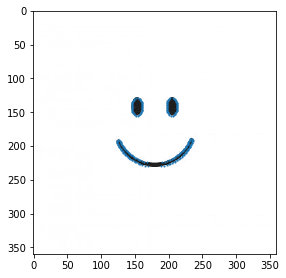

G00 X170 Y129
G01 X188 Y129
G00 X165 Y130
G01 X193 Y130
G00 X161 Y131
G01 X197 Y131
G00 X158 Y132
G01 X200 Y132
G00 X156 Y133
G01 X202 Y133
G00 X154 Y134
G01 X205 Y134
G00 X152 Y135
G01 X168 Y135
G00 X190 Y135
G01 X207 Y135
G00 X150 Y136
G01 X164 Y136
G00 X194 Y136
G01 X209 Y136
G00 X148 Y137
G01 X161 Y137
G00 X198 Y137
G01 X210 Y137
G00 X146 Y138
G01 X158 Y138
G00 X200 Y138
G01 X212 Y138
G00 X145 Y139
G01 X156 Y139
G00 X202 Y139
G01 X213 Y139
G00 X143 Y140
G01 X154 Y140
G00 X205 Y140
G01 X215 Y140
G00 X142 Y141
G01 X152 Y141
G00 X206 Y141
G01 X216 Y141
G00 X141 Y142
G01 X150 Y142
G00 X208 Y142
G01 X217 Y142
G00 X140 Y143
G01 X148 Y143
G00 X210 Y143
G01 X219 Y143
G00 X138 Y144
G01 X147 Y144
G00 X211 Y144
G01 X220 Y144
G00 X137 Y145
G01 X145 Y145
G00 X213 Y145
G01 X221 Y145
G00 X136 Y146
G01 X144 Y146
G00 X214 Y146
G01 X222 Y146
G00 X135 Y147
G01 X143 Y147
G00 X215 Y147
G01 X223 Y147
G00 X134 Y148
G01 X142 Y148
G00 X216 Y148
G01 X224 Y148
G00 X133 Y149
G01 X141 Y149
G00 X217 Y149
G01 X2

----------------------------------------
G00 X194 Y136 ; 
194.0
136.0
G00
----------------------------------------
G01 X209 Y136 ; 
209.0
136.0
G01
----------------------------------------
G00 X148 Y137 ; 
148.0
137.0
G00
----------------------------------------
G01 X161 Y137 ; 
161.0
137.0
G01
----------------------------------------
G00 X198 Y137 ; 
198.0
137.0
G00
----------------------------------------
G01 X210 Y137 ; 
210.0
137.0
G01
----------------------------------------
G00 X146 Y138 ; 
146.0
138.0
G00
----------------------------------------
G01 X158 Y138 ; 
158.0
138.0
G01
----------------------------------------
G00 X200 Y138 ; 
200.0
138.0
G00
----------------------------------------
G01 X212 Y138 ; 
212.0
138.0
G01
----------------------------------------
G00 X145 Y139 ; 
145.0
139.0
G00
----------------------------------------
G01 X156 Y139 ; 
156.0
139.0
G01
----------------------------------------
G00 X202 Y139 ; 
202.0
139.0
G00
--------------------------------------

----------------------------------------
G01 X129 Y165 ; 
129.0
165.0
G01
----------------------------------------
G00 X229 Y165 ; 
229.0
165.0
G00
----------------------------------------
G01 X235 Y165 ; 
235.0
165.0
G01
----------------------------------------
G00 X123 Y166 ; 
123.0
166.0
G00
----------------------------------------
G01 X128 Y166 ; 
128.0
166.0
G01
----------------------------------------
G00 X230 Y166 ; 
230.0
166.0
G00
----------------------------------------
G01 X235 Y166 ; 
235.0
166.0
G01
----------------------------------------
G00 X124 Y167 ; 
124.0
167.0
G00
----------------------------------------
G01 X128 Y167 ; 
128.0
167.0
G01
----------------------------------------
G00 X230 Y167 ; 
230.0
167.0
G00
----------------------------------------
G01 X236 Y167 ; 
236.0
167.0
G01
----------------------------------------
G00 X125 Y168 ; 
125.0
168.0
G00
----------------------------------------
G01 X126 Y168 ; 
126.0
168.0
G01
--------------------------------------

----------------------------------------
G01 X158 Y227 ; 
158.0
227.0
G01
----------------------------------------
G00 X199 Y227 ; 
199.0
227.0
G00
----------------------------------------
G01 X210 Y227 ; 
210.0
227.0
G01
----------------------------------------
G00 X148 Y228 ; 
148.0
228.0
G00
----------------------------------------
G01 X158 Y228 ; 
158.0
228.0
G01
----------------------------------------
G00 X200 Y228 ; 
200.0
228.0
G00
----------------------------------------
G01 X209 Y228 ; 
209.0
228.0
G01
----------------------------------------
G00 X149 Y229 ; 
149.0
229.0
G00
----------------------------------------
G01 X157 Y229 ; 
157.0
229.0
G01
----------------------------------------
G00 X201 Y229 ; 
201.0
229.0
G00
----------------------------------------
G01 X208 Y229 ; 
208.0
229.0
G01
----------------------------------------
G00 X151 Y230 ; 
151.0
230.0
G00
----------------------------------------
G01 X155 Y230 ; 
155.0
230.0
G01
--------------------------------------

G00 X2.985 Y5.501 ; 
2.985
5.501
G00
----------------------------------------
G01 X3.13 Y5.646 ; 
3.13
5.646
G01
----------------------------------------
G00 X2.89 Y6.706 ; 
2.89
6.706
G00
----------------------------------------
G01 X2.89 Y5.731 ; 
2.89
5.731
G01
----------------------------------------
G00 X3.095 Y6.501 ; 
3.095
6.501
G00
----------------------------------------
G01 X3.095 Y5.731 ; 
3.095
5.731
G01
----------------------------------------
G00 X2.89 Y6.706 ; 
2.89
6.706
G00
----------------------------------------
G01 X3.813 Y6.706 ; 
3.813
6.706
G01
----------------------------------------
G00 X3.095 Y6.501 ; 
3.095
6.501
G00
----------------------------------------
G01 X3.813 Y6.501 ; 
3.813
6.501
G01
----------------------------------------
G00 X3.21 Y6.386 ; 
3.21
6.386
G00
----------------------------------------
G01 X3.528 Y6.386 ; 
3.528
6.386
G01
----------------------------------------
G00 X3.415 Y6.181 ; 
3.415
6.181
G00
-------------------------------------

----------------------------------------
G01 X6.734 Y2.861 ; 
6.734
2.861
G01
----------------------------------------
G00 X6.597 Y2.656 ; 
6.597
2.656
G00
----------------------------------------
G01 X6.94 Y2.656 ; 
6.94
2.656
G01
----------------------------------------
G00 X7.054 Y3.302 ; 
7.054
3.302
G00
----------------------------------------
G01 X7.054 Y2.541 ; 
7.054
2.541
G01
----------------------------------------
G00 X7.26 Y3.302 ; 
7.26
3.302
G00
----------------------------------------
G01 X7.26 Y2.336 ; 
7.26
2.336
G01
----------------------------------------
G00 X6.312 Y2.541 ; 
6.312
2.541
G00
----------------------------------------
G01 X7.054 Y2.541 ; 
7.054
2.541
G01
----------------------------------------
G00 X6.312 Y2.336 ; 
6.312
2.336
G00
----------------------------------------
G01 X7.26 Y2.336 ; 
7.26
2.336
G01
----------------------------------------
G00 X4.736 Y3.186 ; 
4.736
3.186
G00
----------------------------------------
G01 X5.02 Y3.186 ; 
5.02
3.186


----------------------------------------
G00 X3.5 Y5.966 ; 
3.5
5.966
G00
----------------------------------------
G01 X3.945 Y6.411 ; 
3.945
6.411
G01
----------------------------------------
G00 X3.5 Y5.966 ; 
3.5
5.966
G00
----------------------------------------
G01 X3.645 Y5.821 ; 
3.645
5.821
G01
----------------------------------------
G00 X3.945 Y6.411 ; 
3.945
6.411
G00
----------------------------------------
G01 X4.09 Y6.266 ; 
4.09
6.266
G01
----------------------------------------
G00 X3.645 Y5.821 ; 
3.645
5.821
G00
----------------------------------------
G01 X4.09 Y6.266 ; 
4.09
6.266
G01
----------------------------------------
G00 X4.115 Y6.581 ; 
4.115
6.581
G00
----------------------------------------
G01 X4.41 Y6.286 ; 
4.41
6.286
G01
----------------------------------------
G00 X4.41 Y6.286 ; 
4.41
6.286
G00
----------------------------------------
G01 X4.265 Y6.141 ; 
4.265
6.141
G01
----------------------------------------
G00 X3.97 Y6.436 ; 
3.97
6.436
G00
----

----------------------------------------
G00 X6.505 Y5.131 ; 
6.505
5.131
G00
----------------------------------------
G01 X6.65 Y4.986 ; 
6.65
4.986
G01
----------------------------------------
G00 X5.885 Y5.451 ; 
5.885
5.451
G00
----------------------------------------
G01 X6.18 Y5.156 ; 
6.18
5.156
G01
----------------------------------------
G00 X5.885 Y5.451 ; 
5.885
5.451
G00
----------------------------------------
G01 X5.74 Y5.306 ; 
5.74
5.306
G01
----------------------------------------
G00 X5.74 Y5.306 ; 
5.74
5.306
G00
----------------------------------------
G01 X6.035 Y5.011 ; 
6.035
5.011
G01
----------------------------------------
G00 X5.69 Y5.646 ; 
5.69
5.646
G00
----------------------------------------
G01 X5.545 Y5.501 ; 
5.545
5.501
G01
----------------------------------------
G00 X5.42 Y5.326 ; 
5.42
5.326
G00
----------------------------------------
G01 X5.865 Y5.771 ; 
5.865
5.771
G01
----------------------------------------
G00 X5.42 Y5.326 ; 
5.42
5.326
G00


----------------------------------------
G01 X6.01 Y3.066 ; 
6.01
3.066
G01
----------------------------------------
G00 X5.42 Y2.766 ; 
5.42
2.766
G00
----------------------------------------
G01 X5.565 Y2.621 ; 
5.565
2.621
G01
----------------------------------------
G00 X6.01 Y3.066 ; 
6.01
3.066
G00
----------------------------------------
G01 X5.565 Y2.621 ; 
5.565
2.621
G01
----------------------------------------
G00 X5.69 Y3.086 ; 
5.69
3.086
G00
----------------------------------------
G01 X5.545 Y2.941 ; 
5.545
2.941
G01
----------------------------------------
G00 X5.25 Y2.596 ; 
5.25
2.596
G00
----------------------------------------
G01 X5.395 Y2.451 ; 
5.395
2.451
G01
----------------------------------------
G00 X5.395 Y2.741 ; 
5.395
2.741
G00
----------------------------------------
G01 X5.54 Y2.596 ; 
5.54
2.596
G01
----------------------------------------
G00 X5.225 Y2.571 ; 
5.225
2.571
G00
----------------------------------------
G01 X5.37 Y2.426 ; 
5.37
2.426
G01


----------------------------------------
G01 X5.1 Y3.386 ; 
5.1
3.386
G01
----------------------------------------
G00 X4.46 Y4.026 ; 
4.46
4.026
G00
----------------------------------------
G01 X4.905 Y3.581 ; 
4.905
3.581
G01
----------------------------------------
G00 X4.46 Y4.026 ; 
4.46
4.026
G00
----------------------------------------
G01 X4.605 Y4.171 ; 
4.605
4.171
G01
----------------------------------------
G00 X4.905 Y3.581 ; 
4.905
3.581
G00
----------------------------------------
G01 X5.05 Y3.726 ; 
5.05
3.726
G01
----------------------------------------
G00 X4.605 Y4.171 ; 
4.605
4.171
G00
----------------------------------------
G01 X5.05 Y3.726 ; 
5.05
3.726
G01
----------------------------------------
G00 X3.97 Y3.876 ; 
3.97
3.876
G00
----------------------------------------
G01 X4.265 Y3.581 ; 
4.265
3.581
G01
----------------------------------------
G00 X4.265 Y3.581 ; 
4.265
3.581
G00
----------------------------------------
G01 X4.41 Y3.726 ; 
4.41
3.726
G01
--

----------------------------------------
G01 X4.905 Y4.861 ; 
4.905
4.861
G01
----------------------------------------
G00 X4.46 Y5.306 ; 
4.46
5.306
G00
----------------------------------------
G01 X4.905 Y4.861 ; 
4.905
4.861
G01
----------------------------------------
G00 X5.245 Y5.451 ; 
5.245
5.451
G00
----------------------------------------
G01 X5.69 Y5.006 ; 
5.69
5.006
G01
----------------------------------------
G00 X5.245 Y5.451 ; 
5.245
5.451
G00
----------------------------------------
G01 X5.1 Y5.306 ; 
5.1
5.306
G01
----------------------------------------
G00 X5.69 Y5.006 ; 
5.69
5.006
G00
----------------------------------------
G01 X5.545 Y4.861 ; 
5.545
4.861
G01
----------------------------------------
G00 X5.1 Y5.306 ; 
5.1
5.306
G00
----------------------------------------
G01 X5.545 Y4.861 ; 
5.545
4.861
G01
----------------------------------------
G00 X4.78 Y4.686 ; 
4.78
4.686
G00
----------------------------------------
G01 X5.225 Y5.131 ; 
5.225
5.131
G01
--

----------------------------------------
G03 R0.341 X6.301 Y6.706 S90 E135 ; 
6.301
6.706
G03
-893.699 -493.294
----------------------------------------
G03 R0.136 X6.301 Y6.501 S90 E135 ; 
6.301
6.501
G03
-893.699 -493.499
----------------------------------------
G03 R0.427 X6.656 Y6.386 S90 E135 ; 
6.656
6.386
G03
-893.344 -493.614
----------------------------------------
G03 R0.222 X6.656 Y6.181 S90 E135 ; 
6.656
6.181
G03
-893.344 -493.819
----------------------------------------
G03 R0.119 X6.7 Y5.966 S315 E360 ; 
6.7
5.966
G03
-893.3 -494.034
----------------------------------------
G03 R0.324 X6.845 Y5.821 S315 E360 ; 
6.845
5.821
G03
-893.155 -494.179
----------------------------------------
G03 R0.205 X6.995 Y5.621 S315 E360 ; 
6.995
5.621
G03
-893.005 -494.379
----------------------------------------
G03 R0.41 X7.14 Y5.476 S315 E360 ; 
7.14
5.476
G03
-892.86 -494.524
----------------------------------------
G03 R0.119 X7.054 Y5.222 S0 E45 ; 
7.054
5.222
G03
-892.946 -494.778


----------------------------------------
G03 R0.187 X6.18 Y2.596 S225 E270 ; 
6.18
2.596
G03
-893.82 -497.404
----------------------------------------
G03 R0.393 X6.035 Y2.451 S225 E270 ; 
6.035
2.451
G03
-893.965 -497.549
----------------------------------------
G03 R0.102 X6.525 Y2.891 S225 E270 ; 
6.525
2.891
G03
-893.475 -497.109
----------------------------------------
G03 R0.307 X6.38 Y2.746 S225 E270 ; 
6.38
2.746
G03
-893.62 -497.254
----------------------------------------
G03 R0.41 X6.94 Y2.947 S0 E45 ; 
6.94
2.947
G03
-893.06 -497.053
----------------------------------------
G03 R0.205 X6.734 Y2.947 S0 E45 ; 
6.734
2.947
G03
-893.266 -497.053
----------------------------------------
G03 R0.324 X7.26 Y3.302 S0 E45 ; 
7.26
3.302
G03
-892.74 -496.698
----------------------------------------
G03 R0.119 X7.054 Y3.302 S0 E45 ; 
7.054
3.302
G03
-892.946 -496.698
----------------------------------------
G03 R0.205 X6.995 Y3.701 S315 E360 ; 
6.995
3.701
G03
-893.005 -496.299
--------

G00 X803 Y461
G01 X807 Y463
G00 X807 Y463
G01 X810 Y466
G00 X810 Y466
G01 X809 Y469
G00 X809 Y469
G01 X808 Y470
G00 X808 Y470
G01 X799 Y472
G00 X799 Y472
G01 X797 Y474
G00 X797 Y474
G01 X796.3 Y476.1
G00 X796.3 Y476.1
G01 X795.7 Y477.9
G00 X795.7 Y477.9
G01 X794.475 Y483.023
G00 X794.475 Y483.023
G01 X792.549 Y513.959
G00 X792.549 Y513.959
G01 X790.647 Y525.912
G00 X790.647 Y525.912
G01 X789.615 Y530.923
G00 X789.615 Y530.923
G01 X786.2 Y542.1
G00 X786.2 Y542.1
G01 X781.2 Y552.1
G00 X781.2 Y552.1
G01 X759.244 Y580.195
G00 X759.244 Y580.195
G01 X754.8 Y586.9
G00 X754.8 Y586.9
G01 X754 Y588
G00 X754 Y588
G01 X754 Y593
G00 X754 Y593
G01 X755 Y594
G00 X755 Y594
G01 X755 Y596
G00 X755 Y596
G01 X751 Y599
G00 X751 Y599
G01 X747 Y599
G00 X747 Y599
G01 X744 Y598
G00 X744 Y598
G01 X741 Y595
G00 X741 Y595
G01 X740 Y592
G00 X740 Y592
G01 X740 Y587
G00 X740 Y587
G01 X741 Y586
G00 X741 Y586
G01 X739 Y584
G00 X739 Y584
G01 X738 Y584
G00 X738 Y584
G01 X735 Y587
G00 X735 Y587
G01 X734.353 Y590.088
G00 

G00 X157 Y426
G01 X155 Y424
G00 X155 Y424
G01 X155 Y416
G00 X155 Y416
G01 X155.647 Y414.912
G00 X155.647 Y414.912
G01 X155.75 Y411.25
G00 X155.75 Y411.25
G01 X151 Y410
G00 X151 Y410
G01 X147 Y410
G00 X147 Y410
G01 X145.9 Y410.8
G00 X145.9 Y410.8
G01 X138 Y414
G00 X138 Y414
G01 X134 Y418
G00 X134 Y418
G01 X129.2 Y425.1
G00 X129.2 Y425.1
G01 X128.8 Y425.9
G00 X128.8 Y425.9
G01 X125.476 Y433.022
G00 X125.476 Y433.022
G01 X124.524 Y453.978
G00 X124.524 Y453.978
G01 X123.76 Y455.82
G00 X123.76 Y455.82
G01 X121 Y459
G00 X121 Y459
G01 X121 Y461
G00 X121 Y461
G01 X122 Y462
G00 X122 Y462
G01 X128.088 Y463.647
G00 X128.088 Y463.647
G01 X133 Y465
G00 X133 Y465
G01 X134 Y466
G00 X134 Y466
G01 X135 Y469
G00 X135 Y469
G01 X131 Y473
G00 X131 Y473
G01 X128.9 Y473.8
G00 X128.9 Y473.8
G01 X124 Y477
G00 X218 Y276
G01 X226 Y281
G00 X226 Y281
G01 X228 Y283
G00 X228 Y283
G01 X225 Y290
G00 X225 Y290
G01 X223 Y292
G00 X223 Y292
G01 X222 Y291
G00 X222 Y291
G01 X221.647 Y288.088
G00 X221.647 Y288.088
G01 X220 Y

G01 X288 Y146
G00 X288 Y146
G01 X277 Y149
G00 X277 Y149
G01 X275 Y151
G00 X275 Y151
G01 X282.088 Y152.647
G00 X282.088 Y152.647
G01 X285 Y153
G00 X285 Y153
G01 X286.2 Y154.9
G00 X286.2 Y154.9
G01 X285.231 Y158.154
G00 X285.231 Y158.154
G01 X283 Y161
G00 X283 Y161
G01 X282.154 Y161.231
G00 X282.154 Y161.231
G01 X268 Y172
G00 X268 Y172
G01 X265.24 Y176.18
G00 X265.24 Y176.18
G01 X257.2 Y190.1
G00 X257.2 Y190.1
G01 X257 Y191
G00 X257 Y191
G01 X243.195 Y204.244
G00 X243.195 Y204.244
G01 X224 Y217
G00 X224 Y217
G01 X224 Y219
G00 X224 Y219
G01 X226.2 Y221.9
G00 X226.2 Y221.9
G01 X228 Y225
G00 X228 Y225
G01 X225 Y231
G00 X225 Y231
G01 X223 Y232
G00 X223 Y232
G01 X212 Y225
G00 X212 Y225
G01 X208.923 Y225.615
G00 X208.923 Y225.615
G01 X201 Y228
G00 X201 Y228
G01 X200 Y229
G00 X200 Y229
G01 X201.24 Y230.82
G00 X201.24 Y230.82
G01 X212 Y246
G00 X212 Y246
G01 X209.2 Y252.1
G00 X209.2 Y252.1
G01 X203 Y259
G00 X203 Y259
G01 X202.154 Y259.231
G00 X202.154 Y259.231
G01 X198 Y262
G00 X198 Y262
G01 X193

G00 X420 Y711 ; 
420.0
711.0
G00
----------------------------------------
G01 X417 Y712 ; 
417.0
712.0
G01
----------------------------------------
G00 X423 Y711 ; 
423.0
711.0
G00
----------------------------------------
G01 X422 Y712 ; 
422.0
712.0
G01
----------------------------------------
G00 X422 Y712 ; 
422.0
712.0
G00
----------------------------------------
G01 X420 Y711 ; 
420.0
711.0
G01
----------------------------------------
G00 X539 Y711 ; 
539.0
711.0
G00
----------------------------------------
G01 X541 Y712 ; 
541.0
712.0
G01
----------------------------------------
G00 X422 Y710 ; 
422.0
710.0
G00
----------------------------------------
G01 X420 Y711 ; 
420.0
711.0
G01
----------------------------------------
G00 X422 Y710 ; 
422.0
710.0
G00
----------------------------------------
G01 X423 Y711 ; 
423.0
711.0
G01
----------------------------------------
G00 X303 Y686 ; 
303.0
686.0
G00
----------------------------------------
G01 X322.1 Y691.7 ; 
322.1
691.7
G01
-

----------------------------------------
G01 X530.9 Y672.8 ; 
530.9
672.8
G01
----------------------------------------
G00 X530.9 Y672.8 ; 
530.9
672.8
G00
----------------------------------------
G01 X534 Y672 ; 
534.0
672.0
G01
----------------------------------------
G00 X444 Y671 ; 
444.0
671.0
G00
----------------------------------------
G01 X442 Y671 ; 
442.0
671.0
G01
----------------------------------------
G00 X415 Y668 ; 
415.0
668.0
G00
----------------------------------------
G01 X417 Y669 ; 
417.0
669.0
G01
----------------------------------------
G00 X417 Y669 ; 
417.0
669.0
G00
----------------------------------------
G01 X419 Y671 ; 
419.0
671.0
G01
----------------------------------------
G00 X419 Y671 ; 
419.0
671.0
G00
----------------------------------------
G01 X419 Y672 ; 
419.0
672.0
G01
----------------------------------------
G00 X419 Y672 ; 
419.0
672.0
G00
----------------------------------------
G01 X416 Y675 ; 
416.0
675.0
G01
------------------------------

----------------------------------------
G00 X468.01 Y672.489 ; 
468.01
672.489
G00
----------------------------------------
G01 X514.75 Y672.25 ; 
514.75
672.25
G01
----------------------------------------
G00 X514.75 Y672.25 ; 
514.75
672.25
G00
----------------------------------------
G01 X515.405 Y677.932 ; 
515.405
677.932
G01
----------------------------------------
G00 X515.405 Y677.932 ; 
515.405
677.932
G00
----------------------------------------
G01 X516 Y680 ; 
516.0
680.0
G01
----------------------------------------
G00 X516 Y680 ; 
516.0
680.0
G00
----------------------------------------
G01 X518 Y682 ; 
518.0
682.0
G01
----------------------------------------
G00 X518 Y682 ; 
518.0
682.0
G00
----------------------------------------
G01 X521 Y680 ; 
521.0
680.0
G01
----------------------------------------
G00 X521 Y680 ; 
521.0
680.0
G00
----------------------------------------
G01 X521 Y676 ; 
521.0
676.0
G01
----------------------------------------
G00 X521 Y676 ; 
521.

----------------------------------------
G00 X372.9 Y650.2 ; 
372.9
650.2
G00
----------------------------------------
G01 X377 Y653 ; 
377.0
653.0
G01
----------------------------------------
G00 X377 Y653 ; 
377.0
653.0
G00
----------------------------------------
G01 X377 Y654 ; 
377.0
654.0
G01
----------------------------------------
G00 X377 Y654 ; 
377.0
654.0
G00
----------------------------------------
G01 X376 Y655 ; 
376.0
655.0
G01
----------------------------------------
G00 X376 Y655 ; 
376.0
655.0
G00
----------------------------------------
G01 X371.9 Y655.7 ; 
371.9
655.7
G01
----------------------------------------
G00 X371.9 Y655.7 ; 
371.9
655.7
G00
----------------------------------------
G01 X365 Y661 ; 
365.0
661.0
G01
----------------------------------------
G00 X365 Y661 ; 
365.0
661.0
G00
----------------------------------------
G01 X362 Y661 ; 
362.0
661.0
G01
----------------------------------------
G00 X362 Y661 ; 
362.0
661.0
G00
--------------------------

----------------------------------------
G00 X338 Y636 ; 
338.0
636.0
G00
----------------------------------------
G01 X340 Y634 ; 
340.0
634.0
G01
----------------------------------------
G00 X340 Y634 ; 
340.0
634.0
G00
----------------------------------------
G01 X341.9 Y635.2 ; 
341.9
635.2
G01
----------------------------------------
G00 X341.9 Y635.2 ; 
341.9
635.2
G00
----------------------------------------
G01 X350 Y640 ; 
350.0
640.0
G01
----------------------------------------
G00 X621 Y634 ; 
621.0
634.0
G00
----------------------------------------
G01 X623 Y638 ; 
623.0
638.0
G01
----------------------------------------
G00 X623 Y638 ; 
623.0
638.0
G00
----------------------------------------
G01 X625.9 Y640.2 ; 
625.9
640.2
G01
----------------------------------------
G00 X625.9 Y640.2 ; 
625.9
640.2
G00
----------------------------------------
G01 X627.088 Y640.647 ; 
627.088
640.647
G01
----------------------------------------
G00 X627.088 Y640.647 ; 
627.088
640.647
G0

----------------------------------------
G01 X638.1 Y640.2 ; 
638.1
640.2
G01
----------------------------------------
G00 X638.1 Y640.2 ; 
638.1
640.2
G00
----------------------------------------
G01 X637 Y641 ; 
637.0
641.0
G01
----------------------------------------
G00 X637 Y641 ; 
637.0
641.0
G00
----------------------------------------
G01 X632 Y635 ; 
632.0
635.0
G01
----------------------------------------
G00 X632 Y635 ; 
632.0
635.0
G00
----------------------------------------
G01 X628.912 Y634.353 ; 
628.912
634.353
G01
----------------------------------------
G00 X628.912 Y634.353 ; 
628.912
634.353
G00
----------------------------------------
G01 X626 Y634 ; 
626.0
634.0
G01
----------------------------------------
G00 X626 Y634 ; 
626.0
634.0
G00
----------------------------------------
G01 X625 Y632 ; 
625.0
632.0
G01
----------------------------------------
G00 X625 Y632 ; 
625.0
632.0
G00
----------------------------------------
G01 X634.9 Y625.8 ; 
634.9
625.8
G01
--

----------------------------------------
G01 X294 Y599 ; 
294.0
599.0
G01
----------------------------------------
G00 X294 Y599 ; 
294.0
599.0
G00
----------------------------------------
G01 X297.231 Y602.846 ; 
297.231
602.846
G01
----------------------------------------
G00 X297.231 Y602.846 ; 
297.231
602.846
G00
----------------------------------------
G01 X299 Y605 ; 
299.0
605.0
G01
----------------------------------------
G00 X299 Y605 ; 
299.0
605.0
G00
----------------------------------------
G01 X296 Y608 ; 
296.0
608.0
G01
----------------------------------------
G00 X296 Y608 ; 
296.0
608.0
G00
----------------------------------------
G01 X295 Y608 ; 
295.0
608.0
G01
----------------------------------------
G00 X295 Y608 ; 
295.0
608.0
G00
----------------------------------------
G01 X293.353 Y611.088 ; 
293.353
611.088
G01
----------------------------------------
G00 X293.353 Y611.088 ; 
293.353
611.088
G00
----------------------------------------
G01 X293 Y614 ; 
293.0


----------------------------------------
G00 X663 Y656 ; 
663.0
656.0
G00
----------------------------------------
G01 X660 Y653 ; 
660.0
653.0
G01
----------------------------------------
G00 X660 Y653 ; 
660.0
653.0
G00
----------------------------------------
G01 X653 Y652 ; 
653.0
652.0
G01
----------------------------------------
G00 X653 Y652 ; 
653.0
652.0
G00
----------------------------------------
G01 X647.1 Y654.2 ; 
647.1
654.2
G01
----------------------------------------
G00 X647.1 Y654.2 ; 
647.1
654.2
G00
----------------------------------------
G01 X645.1 Y655.2 ; 
645.1
655.2
G01
----------------------------------------
G00 X645.1 Y655.2 ; 
645.1
655.2
G00
----------------------------------------
G01 X642 Y657 ; 
642.0
657.0
G01
----------------------------------------
G00 X642 Y657 ; 
642.0
657.0
G00
----------------------------------------
G01 X641.8 Y657.9 ; 
641.8
657.9
G01
----------------------------------------
G00 X641.8 Y657.9 ; 
641.8
657.9
G00
--------------

----------------------------------------
G00 X272 Y578 ; 
272.0
578.0
G00
----------------------------------------
G01 X276 Y581 ; 
276.0
581.0
G01
----------------------------------------
G00 X276 Y581 ; 
276.0
581.0
G00
----------------------------------------
G01 X276.231 Y581.846 ; 
276.231
581.846
G01
----------------------------------------
G00 X276.231 Y581.846 ; 
276.231
581.846
G00
----------------------------------------
G01 X278 Y584 ; 
278.0
584.0
G01
----------------------------------------
G00 X278 Y584 ; 
278.0
584.0
G00
----------------------------------------
G01 X273 Y589 ; 
273.0
589.0
G01
----------------------------------------
G00 X273 Y589 ; 
273.0
589.0
G00
----------------------------------------
G01 X269 Y591 ; 
269.0
591.0
G01
----------------------------------------
G00 X269 Y591 ; 
269.0
591.0
G00
----------------------------------------
G01 X266 Y591 ; 
266.0
591.0
G01
----------------------------------------
G00 X266 Y591 ; 
266.0
591.0
G00
--------------

----------------------------------------
G01 X255 Y614 ; 
255.0
614.0
G01
----------------------------------------
G00 X255 Y614 ; 
255.0
614.0
G00
----------------------------------------
G01 X254.3 Y615.1 ; 
254.3
615.1
G01
----------------------------------------
G00 X254.3 Y615.1 ; 
254.3
615.1
G00
----------------------------------------
G01 X253 Y619 ; 
253.0
619.0
G01
----------------------------------------
G00 X253 Y619 ; 
253.0
619.0
G00
----------------------------------------
G01 X249.1 Y622.2 ; 
249.1
622.2
G01
----------------------------------------
G00 X249.1 Y622.2 ; 
249.1
622.2
G00
----------------------------------------
G01 X245 Y624 ; 
245.0
624.0
G01
----------------------------------------
G00 X245 Y624 ; 
245.0
624.0
G00
----------------------------------------
G01 X238 Y623 ; 
238.0
623.0
G01
----------------------------------------
G00 X238 Y623 ; 
238.0
623.0
G00
----------------------------------------
G01 X237 Y622 ; 
237.0
622.0
G01
----------------------

----------------------------------------
G00 X178 Y550 ; 
178.0
550.0
G00
----------------------------------------
G01 X178 Y555 ; 
178.0
555.0
G01
----------------------------------------
G00 X178 Y555 ; 
178.0
555.0
G00
----------------------------------------
G01 X177 Y556 ; 
177.0
556.0
G01
----------------------------------------
G00 X177 Y556 ; 
177.0
556.0
G00
----------------------------------------
G01 X174.25 Y555.75 ; 
174.25
555.75
G01
----------------------------------------
G00 X174.25 Y555.75 ; 
174.25
555.75
G00
----------------------------------------
G01 X174 Y550 ; 
174.0
550.0
G01
----------------------------------------
G00 X174 Y550 ; 
174.0
550.0
G00
----------------------------------------
G01 X174 Y549 ; 
174.0
549.0
G01
----------------------------------------
G00 X247 Y545 ; 
247.0
545.0
G00
----------------------------------------
G01 X251 Y550 ; 
251.0
550.0
G01
----------------------------------------
G00 X251 Y550 ; 
251.0
550.0
G00
----------------------

----------------------------------------
G01 X739 Y560 ; 
739.0
560.0
G01
----------------------------------------
G00 X739 Y560 ; 
739.0
560.0
G00
----------------------------------------
G01 X739 Y561 ; 
739.0
561.0
G01
----------------------------------------
G00 X739 Y561 ; 
739.0
561.0
G00
----------------------------------------
G01 X742 Y564 ; 
742.0
564.0
G01
----------------------------------------
G00 X742 Y564 ; 
742.0
564.0
G00
----------------------------------------
G01 X748 Y566 ; 
748.0
566.0
G01
----------------------------------------
G00 X748 Y566 ; 
748.0
566.0
G00
----------------------------------------
G01 X758 Y566 ; 
758.0
566.0
G01
----------------------------------------
G00 X758 Y566 ; 
758.0
566.0
G00
----------------------------------------
G01 X761 Y564 ; 
761.0
564.0
G01
----------------------------------------
G00 X761 Y564 ; 
761.0
564.0
G00
----------------------------------------
G01 X750 Y549 ; 
750.0
549.0
G01
--------------------------------------

----------------------------------------
G01 X467 Y716 ; 
467.0
716.0
G01
----------------------------------------
G00 X467 Y716 ; 
467.0
716.0
G00
----------------------------------------
G01 X466 Y708 ; 
466.0
708.0
G01
----------------------------------------
G00 X466 Y708 ; 
466.0
708.0
G00
----------------------------------------
G01 X464 Y706 ; 
464.0
706.0
G01
----------------------------------------
G00 X464 Y706 ; 
464.0
706.0
G00
----------------------------------------
G01 X462 Y708 ; 
462.0
708.0
G01
----------------------------------------
G00 X462 Y708 ; 
462.0
708.0
G00
----------------------------------------
G01 X462 Y717 ; 
462.0
717.0
G01
----------------------------------------
G00 X462 Y717 ; 
462.0
717.0
G00
----------------------------------------
G01 X459 Y719 ; 
459.0
719.0
G01
----------------------------------------
G00 X459 Y719 ; 
459.0
719.0
G00
----------------------------------------
G01 X454 Y719 ; 
454.0
719.0
G01
--------------------------------------

----------------------------------------
G00 X367 Y687 ; 
367.0
687.0
G00
----------------------------------------
G01 X367 Y695 ; 
367.0
695.0
G01
----------------------------------------
G00 X367 Y695 ; 
367.0
695.0
G00
----------------------------------------
G01 X365.1 Y696.2 ; 
365.1
696.2
G01
----------------------------------------
G00 X365.1 Y696.2 ; 
365.1
696.2
G00
----------------------------------------
G01 X364 Y697 ; 
364.0
697.0
G01
----------------------------------------
G00 X364 Y697 ; 
364.0
697.0
G00
----------------------------------------
G01 X360 Y697 ; 
360.0
697.0
G01
----------------------------------------
G00 X360 Y697 ; 
360.0
697.0
G00
----------------------------------------
G01 X358.195 Y695.756 ; 
358.195
695.756
G01
----------------------------------------
G00 X358.195 Y695.756 ; 
358.195
695.756
G00
----------------------------------------
G01 X350 Y689 ; 
350.0
689.0
G01
----------------------------------------
G00 X350 Y689 ; 
350.0
689.0
G00
------

----------------------------------------
G00 X665.82 Y693.76 ; 
665.82
693.76
G00
----------------------------------------
G01 X629.9 Y713.8 ; 
629.9
713.8
G01
----------------------------------------
G00 X629.9 Y713.8 ; 
629.9
713.8
G00
----------------------------------------
G01 X625.9 Y715.8 ; 
625.9
715.8
G01
----------------------------------------
G00 X625.9 Y715.8 ; 
625.9
715.8
G00
----------------------------------------
G01 X592.9 Y728.7 ; 
592.9
728.7
G01
----------------------------------------
G00 X592.9 Y728.7 ; 
592.9
728.7
G00
----------------------------------------
G01 X591.1 Y729.3 ; 
591.1
729.3
G01
----------------------------------------
G00 X591.1 Y729.3 ; 
591.1
729.3
G00
----------------------------------------
G01 X568.1 Y736.3 ; 
568.1
736.3
G01
----------------------------------------
G00 X568.1 Y736.3 ; 
568.1
736.3
G00
----------------------------------------
G01 X548.946 Y740.569 ; 
548.946
740.569
G01
----------------------------------------
G00 X548.94

----------------------------------------
G00 X226 Y534 ; 
226.0
534.0
G00
----------------------------------------
G01 X224 Y532 ; 
224.0
532.0
G01
----------------------------------------
G00 X224 Y532 ; 
224.0
532.0
G00
----------------------------------------
G01 X219.3 Y521.9 ; 
219.3
521.9
G01
----------------------------------------
G00 X219.3 Y521.9 ; 
219.3
521.9
G00
----------------------------------------
G01 X216 Y512 ; 
216.0
512.0
G01
----------------------------------------
G00 X216 Y512 ; 
216.0
512.0
G00
----------------------------------------
G01 X220.7 Y504.9 ; 
220.7
504.9
G01
----------------------------------------
G00 X220.7 Y504.9 ; 
220.7
504.9
G00
----------------------------------------
G01 X221 Y503 ; 
221.0
503.0
G01
----------------------------------------
G00 X221 Y503 ; 
221.0
503.0
G00
----------------------------------------
G01 X220 Y502 ; 
220.0
502.0
G01
----------------------------------------
G00 X220 Y502 ; 
220.0
502.0
G00
----------------------

----------------------------------------
G01 X203 Y458 ; 
203.0
458.0
G01
----------------------------------------
G00 X203 Y458 ; 
203.0
458.0
G00
----------------------------------------
G01 X201.8 Y459.9 ; 
201.8
459.9
G01
----------------------------------------
G00 X201.8 Y459.9 ; 
201.8
459.9
G00
----------------------------------------
G01 X201 Y461 ; 
201.0
461.0
G01
----------------------------------------
G00 X201 Y461 ; 
201.0
461.0
G00
----------------------------------------
G01 X201.8 Y464.1 ; 
201.8
464.1
G01
----------------------------------------
G00 X201.8 Y464.1 ; 
201.8
464.1
G00
----------------------------------------
G01 X203 Y466 ; 
203.0
466.0
G01
----------------------------------------
G00 X203 Y466 ; 
203.0
466.0
G00
----------------------------------------
G01 X210 Y466 ; 
210.0
466.0
G01
----------------------------------------
G00 X210 Y466 ; 
210.0
466.0
G00
----------------------------------------
G01 X212 Y465 ; 
212.0
465.0
G01
----------------------

----------------------------------------
G00 X788 Y423 ; 
788.0
423.0
G00
----------------------------------------
G01 X787 Y423 ; 
787.0
423.0
G01
----------------------------------------
G00 X787 Y423 ; 
787.0
423.0
G00
----------------------------------------
G01 X784.8 Y425.9 ; 
784.8
425.9
G01
----------------------------------------
G00 X784.8 Y425.9 ; 
784.8
425.9
G00
----------------------------------------
G01 X781.451 Y434.041 ; 
781.451
434.041
G01
----------------------------------------
G00 X781.451 Y434.041 ; 
781.451
434.041
G00
----------------------------------------
G01 X779.451 Y464.041 ; 
779.451
464.041
G01
----------------------------------------
G00 X779.451 Y464.041 ; 
779.451
464.041
G00
----------------------------------------
G01 X779 Y474 ; 
779.0
474.0
G01
----------------------------------------
G00 X779 Y474 ; 
779.0
474.0
G00
----------------------------------------
G01 X777 Y476 ; 
777.0
476.0
G01
----------------------------------------
G00 X777 Y476 ;

----------------------------------------
G00 X755 Y596 ; 
755.0
596.0
G00
----------------------------------------
G01 X751 Y599 ; 
751.0
599.0
G01
----------------------------------------
G00 X751 Y599 ; 
751.0
599.0
G00
----------------------------------------
G01 X747 Y599 ; 
747.0
599.0
G01
----------------------------------------
G00 X747 Y599 ; 
747.0
599.0
G00
----------------------------------------
G01 X744 Y598 ; 
744.0
598.0
G01
----------------------------------------
G00 X744 Y598 ; 
744.0
598.0
G00
----------------------------------------
G01 X741 Y595 ; 
741.0
595.0
G01
----------------------------------------
G00 X741 Y595 ; 
741.0
595.0
G00
----------------------------------------
G01 X740 Y592 ; 
740.0
592.0
G01
----------------------------------------
G00 X740 Y592 ; 
740.0
592.0
G00
----------------------------------------
G01 X740 Y587 ; 
740.0
587.0
G01
----------------------------------------
G00 X740 Y587 ; 
740.0
587.0
G00
--------------------------------------

----------------------------------------
G00 X652.9 Y685.8 ; 
652.9
685.8
G00
----------------------------------------
G01 X638.1 Y692.3 ; 
638.1
692.3
G01
----------------------------------------
G00 X638.1 Y692.3 ; 
638.1
692.3
G00
----------------------------------------
G01 X636.9 Y692.7 ; 
636.9
692.7
G01
----------------------------------------
G00 X636.9 Y692.7 ; 
636.9
692.7
G00
----------------------------------------
G01 X627.154 Y696.231 ; 
627.154
696.231
G01
----------------------------------------
G00 X627.154 Y696.231 ; 
627.154
696.231
G00
----------------------------------------
G01 X624 Y698 ; 
624.0
698.0
G01
----------------------------------------
G00 X624 Y698 ; 
624.0
698.0
G00
----------------------------------------
G01 X619.8 Y704.9 ; 
619.8
704.9
G01
----------------------------------------
G00 X619.8 Y704.9 ; 
619.8
704.9
G00
----------------------------------------
G01 X617 Y709 ; 
617.0
709.0
G01
----------------------------------------
G00 X617 Y709 ; 
61

----------------------------------------
G01 X507 Y733 ; 
507.0
733.0
G01
----------------------------------------
G00 X507 Y733 ; 
507.0
733.0
G00
----------------------------------------
G01 X498.1 Y730.7 ; 
498.1
730.7
G01
----------------------------------------
G00 X498.1 Y730.7 ; 
498.1
730.7
G00
----------------------------------------
G01 X493.9 Y729.2 ; 
493.9
729.2
G01
----------------------------------------
G00 X493.9 Y729.2 ; 
493.9
729.2
G00
----------------------------------------
G01 X486 Y724 ; 
486.0
724.0
G01
----------------------------------------
G00 X486 Y724 ; 
486.0
724.0
G00
----------------------------------------
G01 X485.8 Y723.1 ; 
485.8
723.1
G01
----------------------------------------
G00 X485.8 Y723.1 ; 
485.8
723.1
G00
----------------------------------------
G01 X484 Y720 ; 
484.0
720.0
G01
----------------------------------------
G00 X484 Y720 ; 
484.0
720.0
G00
----------------------------------------
G01 X484 Y716 ; 
484.0
716.0
G01
--------------

----------------------------------------
G01 X170.1 Y436.3 ; 
170.1
436.3
G01
----------------------------------------
G00 X170.1 Y436.3 ; 
170.1
436.3
G00
----------------------------------------
G01 X172 Y436 ; 
172.0
436.0
G01
----------------------------------------
G00 X172 Y436 ; 
172.0
436.0
G00
----------------------------------------
G01 X173 Y435 ; 
173.0
435.0
G01
----------------------------------------
G00 X173 Y435 ; 
173.0
435.0
G00
----------------------------------------
G01 X173 Y425 ; 
173.0
425.0
G01
----------------------------------------
G00 X173 Y425 ; 
173.0
425.0
G00
----------------------------------------
G01 X172 Y423 ; 
172.0
423.0
G01
----------------------------------------
G00 X172 Y423 ; 
172.0
423.0
G00
----------------------------------------
G01 X173 Y422 ; 
173.0
422.0
G01
----------------------------------------
G00 X173 Y422 ; 
173.0
422.0
G00
----------------------------------------
G01 X175.2 Y424.9 ; 
175.2
424.9
G01
--------------------------

----------------------------------------
G00 X224 Y575 ; 
224.0
575.0
G00
----------------------------------------
G01 X227.9 Y577.2 ; 
227.9
577.2
G01
----------------------------------------
G00 X227.9 Y577.2 ; 
227.9
577.2
G00
----------------------------------------
G01 X229.1 Y577.8 ; 
229.1
577.8
G01
----------------------------------------
G00 X229.1 Y577.8 ; 
229.1
577.8
G00
----------------------------------------
G01 X238.795 Y583.246 ; 
238.795
583.246
G01
----------------------------------------
G00 X238.795 Y583.246 ; 
238.795
583.246
G00
----------------------------------------
G01 X244.205 Y587.754 ; 
244.205
587.754
G01
----------------------------------------
G00 X244.205 Y587.754 ; 
244.205
587.754
G00
----------------------------------------
G01 X252 Y595 ; 
252.0
595.0
G01
----------------------------------------
G00 X252 Y595 ; 
252.0
595.0
G00
----------------------------------------
G01 X266.76 Y617.18 ; 
266.76
617.18
G01
----------------------------------------

----------------------------------------
G00 X364.951 Y678.439 ; 
364.951
678.439
G00
----------------------------------------
G01 X377.9 Y681.3 ; 
377.9
681.3
G01
----------------------------------------
G00 X377.9 Y681.3 ; 
377.9
681.3
G00
----------------------------------------
G01 X394.9 Y690.2 ; 
394.9
690.2
G01
----------------------------------------
G00 X394.9 Y690.2 ; 
394.9
690.2
G00
----------------------------------------
G01 X406.088 Y695.647 ; 
406.088
695.647
G01
----------------------------------------
G00 X406.088 Y695.647 ; 
406.088
695.647
G00
----------------------------------------
G01 X428.9 Y699.2 ; 
428.9
699.2
G01
----------------------------------------
G00 X428.9 Y699.2 ; 
428.9
699.2
G00
----------------------------------------
G01 X433 Y702 ; 
433.0
702.0
G01
----------------------------------------
G00 X433 Y702 ; 
433.0
702.0
G00
----------------------------------------
G01 X429 Y706 ; 
429.0
706.0
G01
----------------------------------------
G00 X429 Y7

----------------------------------------
G01 X112 Y444 ; 
112.0
444.0
G01
----------------------------------------
G00 X112 Y444 ; 
112.0
444.0
G00
----------------------------------------
G01 X111 Y443 ; 
111.0
443.0
G01
----------------------------------------
G00 X111 Y443 ; 
111.0
443.0
G00
----------------------------------------
G01 X107 Y445 ; 
107.0
445.0
G01
----------------------------------------
G00 X107 Y445 ; 
107.0
445.0
G00
----------------------------------------
G01 X102.9 Y443.2 ; 
102.9
443.2
G01
----------------------------------------
G00 X102.9 Y443.2 ; 
102.9
443.2
G00
----------------------------------------
G01 X100 Y441 ; 
100.0
441.0
G01
----------------------------------------
G00 X100 Y441 ; 
100.0
441.0
G00
----------------------------------------
G01 X97.2 Y434.9 ; 
97.2
434.9
G01
----------------------------------------
G00 X97.2 Y434.9 ; 
97.2
434.9
G00
----------------------------------------
G01 X96 Y433 ; 
96.0
433.0
G01
----------------------------

----------------------------------------
G01 X757 Y436 ; 
757.0
436.0
G01
----------------------------------------
G00 X757 Y436 ; 
757.0
436.0
G00
----------------------------------------
G01 X755 Y438 ; 
755.0
438.0
G01
----------------------------------------
G00 X755 Y438 ; 
755.0
438.0
G00
----------------------------------------
G01 X748.353 Y463.088 ; 
748.353
463.088
G01
----------------------------------------
G00 X748.353 Y463.088 ; 
748.353
463.088
G00
----------------------------------------
G01 X744 Y479 ; 
744.0
479.0
G01
----------------------------------------
G00 X744 Y479 ; 
744.0
479.0
G00
----------------------------------------
G01 X744 Y486 ; 
744.0
486.0
G01
----------------------------------------
G00 X744 Y486 ; 
744.0
486.0
G00
----------------------------------------
G01 X747.1 Y487.8 ; 
747.1
487.8
G01
----------------------------------------
G00 X747.1 Y487.8 ; 
747.1
487.8
G00
----------------------------------------
G01 X751 Y489 ; 
751.0
489.0
G01
------

----------------------------------------
G00 X853 Y445 ; 
853.0
445.0
G00
----------------------------------------
G01 X850 Y442 ; 
850.0
442.0
G01
----------------------------------------
G00 X850 Y442 ; 
850.0
442.0
G00
----------------------------------------
G01 X849 Y443 ; 
849.0
443.0
G01
----------------------------------------
G00 X849 Y443 ; 
849.0
443.0
G00
----------------------------------------
G01 X846.385 Y468.077 ; 
846.385
468.077
G01
----------------------------------------
G00 X846.385 Y468.077 ; 
846.385
468.077
G00
----------------------------------------
G01 X842 Y482 ; 
842.0
482.0
G01
----------------------------------------
G00 X842 Y482 ; 
842.0
482.0
G00
----------------------------------------
G01 X838 Y486 ; 
838.0
486.0
G01
----------------------------------------
G00 X838 Y486 ; 
838.0
486.0
G00
----------------------------------------
G01 X829 Y490 ; 
829.0
490.0
G01
----------------------------------------
G00 X829 Y490 ; 
829.0
490.0
G00
--------------

----------------------------------------
G00 X201 Y375 ; 
201.0
375.0
G00
----------------------------------------
G01 X198 Y379 ; 
198.0
379.0
G01
----------------------------------------
G00 X198 Y379 ; 
198.0
379.0
G00
----------------------------------------
G01 X196 Y377 ; 
196.0
377.0
G01
----------------------------------------
G00 X196 Y377 ; 
196.0
377.0
G00
----------------------------------------
G01 X195 Y372 ; 
195.0
372.0
G01
----------------------------------------
G00 X195 Y372 ; 
195.0
372.0
G00
----------------------------------------
G01 X198 Y369 ; 
198.0
369.0
G01
----------------------------------------
G00 X787 Y367 ; 
787.0
367.0
G00
----------------------------------------
G01 X786 Y368 ; 
786.0
368.0
G01
----------------------------------------
G00 X787 Y367 ; 
787.0
367.0
G00
----------------------------------------
G01 X788 Y369 ; 
788.0
369.0
G01
----------------------------------------
G00 X788 Y369 ; 
788.0
369.0
G00
--------------------------------------

----------------------------------------
G00 X885.75 Y370.75 ; 
885.75
370.75
G00
----------------------------------------
G01 X880.9 Y370.3 ; 
880.9
370.3
G01
----------------------------------------
G00 X880.9 Y370.3 ; 
880.9
370.3
G00
----------------------------------------
G01 X868 Y366 ; 
868.0
366.0
G01
----------------------------------------
G00 X868 Y366 ; 
868.0
366.0
G00
----------------------------------------
G01 X860.1 Y374.2 ; 
860.1
374.2
G01
----------------------------------------
G00 X860.1 Y374.2 ; 
860.1
374.2
G00
----------------------------------------
G01 X859 Y375 ; 
859.0
375.0
G01
----------------------------------------
G00 X859 Y375 ; 
859.0
375.0
G00
----------------------------------------
G01 X822 Y373 ; 
822.0
373.0
G01
----------------------------------------
G00 X822 Y373 ; 
822.0
373.0
G00
----------------------------------------
G01 X813.1 Y376.3 ; 
813.1
376.3
G01
----------------------------------------
G00 X813.1 Y376.3 ; 
813.1
376.3
G00
------

----------------------------------------
G00 X205 Y345 ; 
205.0
345.0
G00
----------------------------------------
G01 X202 Y348 ; 
202.0
348.0
G01
----------------------------------------
G00 X202 Y348 ; 
202.0
348.0
G00
----------------------------------------
G01 X200 Y348 ; 
200.0
348.0
G01
----------------------------------------
G00 X200 Y348 ; 
200.0
348.0
G00
----------------------------------------
G01 X198 Y346 ; 
198.0
346.0
G01
----------------------------------------
G00 X198 Y346 ; 
198.0
346.0
G00
----------------------------------------
G01 X198 Y344 ; 
198.0
344.0
G01
----------------------------------------
G00 X198 Y344 ; 
198.0
344.0
G00
----------------------------------------
G01 X201 Y341 ; 
201.0
341.0
G01
----------------------------------------
G00 X201 Y341 ; 
201.0
341.0
G00
----------------------------------------
G01 X202 Y341 ; 
202.0
341.0
G01
----------------------------------------
G00 X760 Y341 ; 
760.0
341.0
G00
--------------------------------------

----------------------------------------
G00 X217 Y305 ; 
217.0
305.0
G00
----------------------------------------
G01 X218 Y306 ; 
218.0
306.0
G01
----------------------------------------
G00 X218 Y306 ; 
218.0
306.0
G00
----------------------------------------
G01 X217.405 Y310.068 ; 
217.405
310.068
G01
----------------------------------------
G00 X217.405 Y310.068 ; 
217.405
310.068
G00
----------------------------------------
G01 X206 Y357 ; 
206.0
357.0
G01
----------------------------------------
G00 X206 Y357 ; 
206.0
357.0
G00
----------------------------------------
G01 X204 Y359 ; 
204.0
359.0
G01
----------------------------------------
G00 X204 Y359 ; 
204.0
359.0
G00
----------------------------------------
G01 X201.9 Y358.2 ; 
201.9
358.2
G01
----------------------------------------
G00 X201.9 Y358.2 ; 
201.9
358.2
G00
----------------------------------------
G01 X201 Y358 ; 
201.0
358.0
G01
----------------------------------------
G00 X201 Y358 ; 
201.0
358.0
G00
------

----------------------------------------
G00 X764.24 Y391.82 ; 
764.24
391.82
G00
----------------------------------------
G01 X771 Y400 ; 
771.0
400.0
G01
----------------------------------------
G00 X754 Y297 ; 
754.0
297.0
G00
----------------------------------------
G01 X754 Y299 ; 
754.0
299.0
G01
----------------------------------------
G00 X126 Y292 ; 
126.0
292.0
G00
----------------------------------------
G01 X132 Y301 ; 
132.0
301.0
G01
----------------------------------------
G00 X132 Y301 ; 
132.0
301.0
G00
----------------------------------------
G01 X132 Y331 ; 
132.0
331.0
G01
----------------------------------------
G00 X132 Y331 ; 
132.0
331.0
G00
----------------------------------------
G01 X130 Y334 ; 
130.0
334.0
G01
----------------------------------------
G00 X130 Y334 ; 
130.0
334.0
G00
----------------------------------------
G01 X128 Y334 ; 
128.0
334.0
G01
----------------------------------------
G00 X128 Y334 ; 
128.0
334.0
G00
------------------------------

----------------------------------------
G00 X795 Y423 ; 
795.0
423.0
G00
----------------------------------------
G01 X795 Y417 ; 
795.0
417.0
G01
----------------------------------------
G00 X795 Y417 ; 
795.0
417.0
G00
----------------------------------------
G01 X795.8 Y415.9 ; 
795.8
415.9
G01
----------------------------------------
G00 X795.8 Y415.9 ; 
795.8
415.9
G00
----------------------------------------
G01 X797 Y413 ; 
797.0
413.0
G01
----------------------------------------
G00 X797 Y413 ; 
797.0
413.0
G00
----------------------------------------
G01 X803 Y407 ; 
803.0
407.0
G01
----------------------------------------
G00 X803 Y407 ; 
803.0
407.0
G00
----------------------------------------
G01 X808 Y406 ; 
808.0
406.0
G01
----------------------------------------
G00 X808 Y406 ; 
808.0
406.0
G00
----------------------------------------
G01 X813 Y406 ; 
813.0
406.0
G01
----------------------------------------
G00 X813 Y406 ; 
813.0
406.0
G00
------------------------------

----------------------------------------
G00 X901.783 Y352.248 ; 
901.783
352.248
G00
----------------------------------------
G01 X909.217 Y358.752 ; 
909.217
358.752
G01
----------------------------------------
G00 X909.217 Y358.752 ; 
909.217
358.752
G00
----------------------------------------
G01 X917.24 Y366.82 ; 
917.24
366.82
G01
----------------------------------------
G00 X917.24 Y366.82 ; 
917.24
366.82
G00
----------------------------------------
G01 X920.231 Y370.846 ; 
920.231
370.846
G01
----------------------------------------
G00 X920.231 Y370.846 ; 
920.231
370.846
G00
----------------------------------------
G01 X926.7 Y381.1 ; 
926.7
381.1
G01
----------------------------------------
G00 X926.7 Y381.1 ; 
926.7
381.1
G00
----------------------------------------
G01 X927.3 Y382.9 ; 
927.3
382.9
G01
----------------------------------------
G00 X927.3 Y382.9 ; 
927.3
382.9
G00
----------------------------------------
G01 X930.561 Y392.049 ; 
930.561
392.049
G01
--------

----------------------------------------
G01 X108.353 Y416.088 ; 
108.353
416.088
G01
----------------------------------------
G00 X108.353 Y416.088 ; 
108.353
416.088
G00
----------------------------------------
G01 X110.545 Y406.962 ; 
110.545
406.962
G01
----------------------------------------
G00 X110.545 Y406.962 ; 
110.545
406.962
G00
----------------------------------------
G01 X110.75 Y395.25 ; 
110.75
395.25
G01
----------------------------------------
G00 X110.75 Y395.25 ; 
110.75
395.25
G00
----------------------------------------
G01 X104.077 Y396.385 ; 
104.077
396.385
G01
----------------------------------------
G00 X104.077 Y396.385 ; 
104.077
396.385
G00
----------------------------------------
G01 X98 Y398 ; 
98.0
398.0
G01
----------------------------------------
G00 X98 Y398 ; 
98.0
398.0
G00
----------------------------------------
G01 X84 Y398 ; 
84.0
398.0
G01
----------------------------------------
G00 X84 Y398 ; 
84.0
398.0
G00
--------------------------------

----------------------------------------
G01 X153 Y307 ; 
153.0
307.0
G01
----------------------------------------
G00 X153 Y307 ; 
153.0
307.0
G00
----------------------------------------
G01 X153 Y310 ; 
153.0
310.0
G01
----------------------------------------
G00 X153 Y310 ; 
153.0
310.0
G00
----------------------------------------
G01 X150 Y314 ; 
150.0
314.0
G01
----------------------------------------
G00 X150 Y314 ; 
150.0
314.0
G00
----------------------------------------
G01 X146.9 Y314.8 ; 
146.9
314.8
G01
----------------------------------------
G00 X146.9 Y314.8 ; 
146.9
314.8
G00
----------------------------------------
G01 X144.9 Y315.8 ; 
144.9
315.8
G01
----------------------------------------
G00 X144.9 Y315.8 ; 
144.9
315.8
G00
----------------------------------------
G01 X141 Y319 ; 
141.0
319.0
G01
----------------------------------------
G00 X141 Y319 ; 
141.0
319.0
G00
----------------------------------------
G01 X141 Y330 ; 
141.0
330.0
G01
----------------------

----------------------------------------
G00 X125.476 Y433.022 ; 
125.476
433.022
G00
----------------------------------------
G01 X124.524 Y453.978 ; 
124.524
453.978
G01
----------------------------------------
G00 X124.524 Y453.978 ; 
124.524
453.978
G00
----------------------------------------
G01 X123.76 Y455.82 ; 
123.76
455.82
G01
----------------------------------------
G00 X123.76 Y455.82 ; 
123.76
455.82
G00
----------------------------------------
G01 X121 Y459 ; 
121.0
459.0
G01
----------------------------------------
G00 X121 Y459 ; 
121.0
459.0
G00
----------------------------------------
G01 X121 Y461 ; 
121.0
461.0
G01
----------------------------------------
G00 X121 Y461 ; 
121.0
461.0
G00
----------------------------------------
G01 X122 Y462 ; 
122.0
462.0
G01
----------------------------------------
G00 X122 Y462 ; 
122.0
462.0
G00
----------------------------------------
G01 X128.088 Y463.647 ; 
128.088
463.647
G01
----------------------------------------
G00 X12

----------------------------------------
G00 X219.25 Y271.75 ; 
219.25
271.75
G00
----------------------------------------
G01 X219 Y271 ; 
219.0
271.0
G01
----------------------------------------
G00 X219 Y271 ; 
219.0
271.0
G00
----------------------------------------
G01 X223 Y261 ; 
223.0
261.0
G01
----------------------------------------
G00 X737 Y261 ; 
737.0
261.0
G00
----------------------------------------
G01 X739.7 Y265.1 ; 
739.7
265.1
G01
----------------------------------------
G00 X739.7 Y265.1 ; 
739.7
265.1
G00
----------------------------------------
G01 X742 Y271 ; 
742.0
271.0
G01
----------------------------------------
G00 X742 Y271 ; 
742.0
271.0
G00
----------------------------------------
G01 X741 Y272 ; 
741.0
272.0
G01
----------------------------------------
G00 X741 Y272 ; 
741.0
272.0
G00
----------------------------------------
G01 X739 Y271 ; 
739.0
271.0
G01
----------------------------------------
G00 X739 Y271 ; 
739.0
271.0
G00
----------------------

----------------------------------------
G00 X776 Y290 ; 
776.0
290.0
G00
----------------------------------------
G01 X769 Y291 ; 
769.0
291.0
G01
----------------------------------------
G00 X769 Y291 ; 
769.0
291.0
G00
----------------------------------------
G01 X767 Y293 ; 
767.0
293.0
G01
----------------------------------------
G00 X767 Y293 ; 
767.0
293.0
G00
----------------------------------------
G01 X768.595 Y302.068 ; 
768.595
302.068
G01
----------------------------------------
G00 X768.595 Y302.068 ; 
768.595
302.068
G00
----------------------------------------
G01 X770 Y311 ; 
770.0
311.0
G01
----------------------------------------
G00 X770 Y311 ; 
770.0
311.0
G00
----------------------------------------
G01 X772 Y313 ; 
772.0
313.0
G01
----------------------------------------
G00 X772 Y313 ; 
772.0
313.0
G00
----------------------------------------
G01 X777 Y313 ; 
777.0
313.0
G01
----------------------------------------
G00 X777 Y313 ; 
777.0
313.0
G00
--------------

----------------------------------------
G00 X257 Y211 ; 
257.0
211.0
G00
----------------------------------------
G01 X260 Y213 ; 
260.0
213.0
G01
----------------------------------------
G00 X260 Y213 ; 
260.0
213.0
G00
----------------------------------------
G01 X264.2 Y219.9 ; 
264.2
219.9
G01
----------------------------------------
G00 X264.2 Y219.9 ; 
264.2
219.9
G00
----------------------------------------
G01 X265 Y223 ; 
265.0
223.0
G01
----------------------------------------
G00 X265 Y223 ; 
265.0
223.0
G00
----------------------------------------
G01 X261 Y228 ; 
261.0
228.0
G01
----------------------------------------
G00 X261 Y228 ; 
261.0
228.0
G00
----------------------------------------
G01 X259 Y226 ; 
259.0
226.0
G01
----------------------------------------
G00 X259 Y226 ; 
259.0
226.0
G00
----------------------------------------
G01 X258.3 Y222.9 ; 
258.3
222.9
G01
----------------------------------------
G00 X258.3 Y222.9 ; 
258.3
222.9
G00
----------------------

----------------------------------------
G00 X282.1 Y202.2 ; 
282.1
202.2
G00
----------------------------------------
G01 X281 Y203 ; 
281.0
203.0
G01
----------------------------------------
G00 X281 Y203 ; 
281.0
203.0
G00
----------------------------------------
G01 X279 Y201 ; 
279.0
201.0
G01
----------------------------------------
G00 X279 Y201 ; 
279.0
201.0
G00
----------------------------------------
G01 X279 Y200 ; 
279.0
200.0
G01
----------------------------------------
G00 X279 Y200 ; 
279.0
200.0
G00
----------------------------------------
G01 X271 Y197 ; 
271.0
197.0
G01
----------------------------------------
G00 X271 Y197 ; 
271.0
197.0
G00
----------------------------------------
G01 X271 Y195 ; 
271.0
195.0
G01
----------------------------------------
G00 X271 Y195 ; 
271.0
195.0
G00
----------------------------------------
G01 X274.846 Y191.769 ; 
274.846
191.769
G01
----------------------------------------
G00 X274.846 Y191.769 ; 
274.846
191.769
G00
----------

----------------------------------------
G00 X652.8 Y178.1 ; 
652.8
178.1
G00
----------------------------------------
G01 X652 Y177 ; 
652.0
177.0
G01
----------------------------------------
G00 X652 Y177 ; 
652.0
177.0
G00
----------------------------------------
G01 X655.088 Y175.353 ; 
655.088
175.353
G01
----------------------------------------
G00 X655.088 Y175.353 ; 
655.088
175.353
G00
----------------------------------------
G01 X658 Y175 ; 
658.0
175.0
G01
----------------------------------------
G00 X658 Y175 ; 
658.0
175.0
G00
----------------------------------------
G01 X659 Y174 ; 
659.0
174.0
G01
----------------------------------------
G00 X659 Y174 ; 
659.0
174.0
G00
----------------------------------------
G01 X659 Y172 ; 
659.0
172.0
G01
----------------------------------------
G00 X659 Y172 ; 
659.0
172.0
G00
----------------------------------------
G01 X656 Y169 ; 
656.0
169.0
G01
----------------------------------------
G00 X656 Y169 ; 
656.0
169.0
G00
----------

----------------------------------------
G00 X355.088 Y143.647 ; 
355.088
143.647
G00
----------------------------------------
G01 X358 Y144 ; 
358.0
144.0
G01
----------------------------------------
G00 X358 Y144 ; 
358.0
144.0
G00
----------------------------------------
G01 X360 Y146 ; 
360.0
146.0
G01
----------------------------------------
G00 X360 Y146 ; 
360.0
146.0
G00
----------------------------------------
G01 X358.1 Y147.2 ; 
358.1
147.2
G01
----------------------------------------
G00 X358.1 Y147.2 ; 
358.1
147.2
G00
----------------------------------------
G01 X354.9 Y148.7 ; 
354.9
148.7
G01
----------------------------------------
G00 X354.9 Y148.7 ; 
354.9
148.7
G00
----------------------------------------
G01 X351 Y150 ; 
351.0
150.0
G01
----------------------------------------
G00 X351 Y150 ; 
351.0
150.0
G00
----------------------------------------
G01 X345 Y145 ; 
345.0
145.0
G01
----------------------------------------
G00 X345 Y145 ; 
345.0
145.0
G00
----------

----------------------------------------
G00 X517.959 Y129.451 ; 
517.959
129.451
G00
----------------------------------------
G01 X530.912 Y132.353 ; 
530.912
132.353
G01
----------------------------------------
G00 X530.912 Y132.353 ; 
530.912
132.353
G00
----------------------------------------
G01 X539.912 Y134.353 ; 
539.912
134.353
G01
----------------------------------------
G00 X539.912 Y134.353 ; 
539.912
134.353
G00
----------------------------------------
G01 X557.1 Y138.8 ; 
557.1
138.8
G01
----------------------------------------
G00 X557.1 Y138.8 ; 
557.1
138.8
G00
----------------------------------------
G01 X577.9 Y146.3 ; 
577.9
146.3
G01
----------------------------------------
G00 X577.9 Y146.3 ; 
577.9
146.3
G00
----------------------------------------
G01 X593.9 Y153.2 ; 
593.9
153.2
G01
----------------------------------------
G00 X593.9 Y153.2 ; 
593.9
153.2
G00
----------------------------------------
G01 X603.1 Y157.8 ; 
603.1
157.8
G01
------------------------

----------------------------------------
G00 X291.75 Y583.235 ; 
291.75
583.235
G00
----------------------------------------
G01 X276.25 Y566.765 ; 
276.25
566.765
G01
----------------------------------------
G00 X276.25 Y566.765 ; 
276.25
566.765
G00
----------------------------------------
G01 X258.24 Y542.82 ; 
258.24
542.82
G01
----------------------------------------
G00 X258.24 Y542.82 ; 
258.24
542.82
G00
----------------------------------------
G01 X247.231 Y524.846 ; 
247.231
524.846
G01
----------------------------------------
G00 X247.231 Y524.846 ; 
247.231
524.846
G00
----------------------------------------
G01 X239.8 Y511.1 ; 
239.8
511.1
G01
----------------------------------------
G00 X239.8 Y511.1 ; 
239.8
511.1
G00
----------------------------------------
G01 X233.3 Y496.9 ; 
233.3
496.9
G01
----------------------------------------
G00 X233.3 Y496.9 ; 
233.3
496.9
G00
----------------------------------------
G01 X225.7 Y474.1 ; 
225.7
474.1
G01
----------------------

----------------------------------------
G01 X598 Y131 ; 
598.0
131.0
G01
----------------------------------------
G00 X598 Y131 ; 
598.0
131.0
G00
----------------------------------------
G01 X603 Y132 ; 
603.0
132.0
G01
----------------------------------------
G00 X603 Y132 ; 
603.0
132.0
G00
----------------------------------------
G01 X604 Y133 ; 
604.0
133.0
G01
----------------------------------------
G00 X604 Y133 ; 
604.0
133.0
G00
----------------------------------------
G01 X602 Y138 ; 
602.0
138.0
G01
----------------------------------------
G00 X602 Y138 ; 
602.0
138.0
G00
----------------------------------------
G01 X597 Y142 ; 
597.0
142.0
G01
----------------------------------------
G00 X597 Y142 ; 
597.0
142.0
G00
----------------------------------------
G01 X587.9 Y140.3 ; 
587.9
140.3
G01
----------------------------------------
G00 X587.9 Y140.3 ; 
587.9
140.3
G00
----------------------------------------
G01 X584.1 Y138.8 ; 
584.1
138.8
G01
--------------------------

----------------------------------------
G01 X508 Y113 ; 
508.0
113.0
G01
----------------------------------------
G00 X508 Y113 ; 
508.0
113.0
G00
----------------------------------------
G01 X508 Y114 ; 
508.0
114.0
G01
----------------------------------------
G00 X508 Y114 ; 
508.0
114.0
G00
----------------------------------------
G01 X505 Y117 ; 
505.0
117.0
G01
----------------------------------------
G00 X505 Y117 ; 
505.0
117.0
G00
----------------------------------------
G01 X503 Y117 ; 
503.0
117.0
G01
----------------------------------------
G00 X503 Y117 ; 
503.0
117.0
G00
----------------------------------------
G01 X501 Y114 ; 
501.0
114.0
G01
----------------------------------------
G00 X501 Y114 ; 
501.0
114.0
G00
----------------------------------------
G01 X501 Y112 ; 
501.0
112.0
G01
----------------------------------------
G00 X501 Y112 ; 
501.0
112.0
G00
----------------------------------------
G01 X505 Y110 ; 
505.0
110.0
G01
--------------------------------------

----------------------------------------
G01 X391 Y133 ; 
391.0
133.0
G01
----------------------------------------
G00 X391 Y133 ; 
391.0
133.0
G00
----------------------------------------
G01 X384 Y122 ; 
384.0
122.0
G01
----------------------------------------
G00 X384 Y122 ; 
384.0
122.0
G00
----------------------------------------
G01 X385 Y120 ; 
385.0
120.0
G01
----------------------------------------
G00 X385 Y120 ; 
385.0
120.0
G00
----------------------------------------
G01 X390 Y121 ; 
390.0
121.0
G01
----------------------------------------
G00 X390 Y121 ; 
390.0
121.0
G00
----------------------------------------
G01 X392 Y123 ; 
392.0
123.0
G01
----------------------------------------
G00 X392 Y123 ; 
392.0
123.0
G00
----------------------------------------
G01 X392 Y124 ; 
392.0
124.0
G01
----------------------------------------
G00 X392 Y124 ; 
392.0
124.0
G00
----------------------------------------
G01 X395 Y127 ; 
395.0
127.0
G01
--------------------------------------

----------------------------------------
G00 X227.2 Y547.9 ; 
227.2
547.9
G00
----------------------------------------
G01 X216.2 Y528.9 ; 
216.2
528.9
G01
----------------------------------------
G00 X216.2 Y528.9 ; 
216.2
528.9
G00
----------------------------------------
G01 X206.7 Y508.1 ; 
206.7
508.1
G01
----------------------------------------
G00 X206.7 Y508.1 ; 
206.7
508.1
G00
----------------------------------------
G01 X200.3 Y490.9 ; 
200.3
490.9
G01
----------------------------------------
G00 X200.3 Y490.9 ; 
200.3
490.9
G00
----------------------------------------
G01 X191.385 Y459.923 ; 
191.385
459.923
G01
----------------------------------------
G00 X191.385 Y459.923 ; 
191.385
459.923
G00
----------------------------------------
G01 X185 Y418 ; 
185.0
418.0
G01
----------------------------------------
G00 X185 Y418 ; 
185.0
418.0
G00
----------------------------------------
G01 X185 Y373 ; 
185.0
373.0
G01
----------------------------------------
G00 X185 Y373 ; 
18

----------------------------------------
G00 X711.769 Y583.846 ; 
711.769
583.846
G00
----------------------------------------
G01 X710 Y586 ; 
710.0
586.0
G01
----------------------------------------
G00 X421 Y82 ; 
421.0
82.0
G00
----------------------------------------
G01 X422.1 Y82.7 ; 
422.1
82.7
G01
----------------------------------------
G00 X422.1 Y82.7 ; 
422.1
82.7
G00
----------------------------------------
G01 X430 Y86 ; 
430.0
86.0
G01
----------------------------------------
G00 X430 Y86 ; 
430.0
86.0
G00
----------------------------------------
G01 X433 Y89 ; 
433.0
89.0
G01
----------------------------------------
G00 X433 Y89 ; 
433.0
89.0
G00
----------------------------------------
G01 X430 Y93 ; 
430.0
93.0
G01
----------------------------------------
G00 X430 Y93 ; 
430.0
93.0
G00
----------------------------------------
G01 X424 Y95 ; 
424.0
95.0
G01
----------------------------------------
G00 X424 Y95 ; 
424.0
95.0
G00
----------------------------------------

----------------------------------------
G00 X286.2 Y154.9 ; 
286.2
154.9
G00
----------------------------------------
G01 X285.231 Y158.154 ; 
285.231
158.154
G01
----------------------------------------
G00 X285.231 Y158.154 ; 
285.231
158.154
G00
----------------------------------------
G01 X283 Y161 ; 
283.0
161.0
G01
----------------------------------------
G00 X283 Y161 ; 
283.0
161.0
G00
----------------------------------------
G01 X282.154 Y161.231 ; 
282.154
161.231
G01
----------------------------------------
G00 X282.154 Y161.231 ; 
282.154
161.231
G00
----------------------------------------
G01 X268 Y172 ; 
268.0
172.0
G01
----------------------------------------
G00 X268 Y172 ; 
268.0
172.0
G00
----------------------------------------
G01 X265.24 Y176.18 ; 
265.24
176.18
G01
----------------------------------------
G00 X265.24 Y176.18 ; 
265.24
176.18
G00
----------------------------------------
G01 X257.2 Y190.1 ; 
257.2
190.1
G01
----------------------------------------

----------------------------------------
G01 X639.8 Y115.9 ; 
639.8
115.9
G01
----------------------------------------
G00 X639.8 Y115.9 ; 
639.8
115.9
G00
----------------------------------------
G01 X637 Y122 ; 
637.0
122.0
G01
----------------------------------------
G00 X637 Y122 ; 
637.0
122.0
G00
----------------------------------------
G01 X639 Y130 ; 
639.0
130.0
G01
----------------------------------------
G00 X639 Y130 ; 
639.0
130.0
G00
----------------------------------------
G01 X645.846 Y136.231 ; 
645.846
136.231
G01
----------------------------------------
G00 X645.846 Y136.231 ; 
645.846
136.231
G00
----------------------------------------
G01 X653 Y140 ; 
653.0
140.0
G01
----------------------------------------
G00 X653 Y140 ; 
653.0
140.0
G00
----------------------------------------
G01 X656 Y140 ; 
656.0
140.0
G01
----------------------------------------
G00 X656 Y140 ; 
656.0
140.0
G00
----------------------------------------
G01 X660 Y138 ; 
660.0
138.0
G01
------

----------------------------------------
G01 X751 Y242 ; 
751.0
242.0
G01
----------------------------------------
G00 X751 Y242 ; 
751.0
242.0
G00
----------------------------------------
G01 X751 Y251 ; 
751.0
251.0
G01
----------------------------------------
G00 X751 Y251 ; 
751.0
251.0
G00
----------------------------------------
G01 X751.8 Y252.1 ; 
751.8
252.1
G01
----------------------------------------
G00 X751.8 Y252.1 ; 
751.8
252.1
G00
----------------------------------------
G01 X753 Y255 ; 
753.0
255.0
G01
----------------------------------------
G00 X753 Y255 ; 
753.0
255.0
G00
----------------------------------------
G01 X759 Y261 ; 
759.0
261.0
G01
----------------------------------------
G00 X759 Y261 ; 
759.0
261.0
G00
----------------------------------------
G01 X763 Y263 ; 
763.0
263.0
G01
----------------------------------------
G00 X763 Y263 ; 
763.0
263.0
G00
----------------------------------------
G01 X770 Y261 ; 
770.0
261.0
G01
------------------------------

----------------------------------------
G00 X565 Y87 ; 
565.0
87.0
G00
----------------------------------------
G01 X565.647 Y89.088 ; 
565.647
89.088
G01
----------------------------------------
G00 X565.647 Y89.088 ; 
565.647
89.088
G00
----------------------------------------
G01 X567 Y94 ; 
567.0
94.0
G01
----------------------------------------
G00 X567 Y94 ; 
567.0
94.0
G00
----------------------------------------
G01 X574 Y101 ; 
574.0
101.0
G01
----------------------------------------
G00 X574 Y101 ; 
574.0
101.0
G00
----------------------------------------
G01 X576.1 Y101.8 ; 
576.1
101.8
G01
----------------------------------------
G00 X576.1 Y101.8 ; 
576.1
101.8
G00
----------------------------------------
G01 X578.9 Y103.2 ; 
578.9
103.2
G01
----------------------------------------
G00 X578.9 Y103.2 ; 
578.9
103.2
G00
----------------------------------------
G01 X587 Y106 ; 
587.0
106.0
G01
----------------------------------------
G00 X587 Y106 ; 
587.0
106.0
G00
--------

----------------------------------------
G00 X722 Y170 ; 
722.0
170.0
G00
----------------------------------------
G01 X723 Y170 ; 
723.0
170.0
G01
----------------------------------------
G00 X723 Y170 ; 
723.0
170.0
G00
----------------------------------------
G01 X724 Y169 ; 
724.0
169.0
G01
----------------------------------------
G00 X724 Y169 ; 
724.0
169.0
G00
----------------------------------------
G01 X723 Y168 ; 
723.0
168.0
G01
----------------------------------------
G00 X723 Y168 ; 
723.0
168.0
G00
----------------------------------------
G01 X716 Y168 ; 
716.0
168.0
G01
----------------------------------------
G00 X716 Y168 ; 
716.0
168.0
G00
----------------------------------------
G01 X711.1 Y170.3 ; 
711.1
170.3
G01
----------------------------------------
G00 X711.1 Y170.3 ; 
711.1
170.3
G00
----------------------------------------
G01 X708 Y172 ; 
708.0
172.0
G01
----------------------------------------
G00 X708 Y172 ; 
708.0
172.0
G00
------------------------------

----------------------------------------
G00 X797 Y349 ; 
797.0
349.0
G00
----------------------------------------
G01 X799 Y350 ; 
799.0
350.0
G01
----------------------------------------
G00 X799 Y350 ; 
799.0
350.0
G00
----------------------------------------
G01 X800 Y353 ; 
800.0
353.0
G01
----------------------------------------
G00 X800 Y353 ; 
800.0
353.0
G00
----------------------------------------
G01 X794.932 Y354.595 ; 
794.932
354.595
G01
----------------------------------------
G00 X794.932 Y354.595 ; 
794.932
354.595
G00
----------------------------------------
G01 X790 Y355 ; 
790.0
355.0
G01
----------------------------------------
G00 X790 Y355 ; 
790.0
355.0
G00
----------------------------------------
G01 X788 Y357 ; 
788.0
357.0
G01
----------------------------------------
G00 X788 Y357 ; 
788.0
357.0
G00
----------------------------------------
G01 X787.42 Y361.06 ; 
787.42
361.06
G01
----------------------------------------
G00 X787.42 Y361.06 ; 
787.42
361.06
G0

----------------------------------------
G00 X192.405 Y299.068 ; 
192.405
299.068
G00
----------------------------------------
G01 X190 Y312 ; 
190.0
312.0
G01
----------------------------------------
G00 X190 Y312 ; 
190.0
312.0
G00
----------------------------------------
G01 X183 Y317 ; 
183.0
317.0
G01
----------------------------------------
G00 X183 Y317 ; 
183.0
317.0
G00
----------------------------------------
G01 X181.446 Y325.045 ; 
181.446
325.045
G01
----------------------------------------
G00 X181.446 Y325.045 ; 
181.446
325.045
G00
----------------------------------------
G01 X178.554 Y353.955 ; 
178.554
353.955
G01
----------------------------------------
G00 X178.554 Y353.955 ; 
178.554
353.955
G00
----------------------------------------
G01 X176.2 Y364.1 ; 
176.2
364.1
G01
----------------------------------------
G00 X176.2 Y364.1 ; 
176.2
364.1
G00
----------------------------------------
G01 X174 Y370 ; 
174.0
370.0
G01
----------------------------------------
G00

----------------------------------------
G00 X253 Y173 ; 
253.0
173.0
G00
----------------------------------------
G01 X250 Y170 ; 
250.0
170.0
G01
----------------------------------------
G00 X250 Y170 ; 
250.0
170.0
G00
----------------------------------------
G01 X245 Y168 ; 
245.0
168.0
G01
----------------------------------------
G00 X245 Y168 ; 
245.0
168.0
G00
----------------------------------------
G01 X239 Y168 ; 
239.0
168.0
G01
----------------------------------------
G00 X239 Y168 ; 
239.0
168.0
G00
----------------------------------------
G01 X238 Y170 ; 
238.0
170.0
G01
----------------------------------------
G00 X238 Y170 ; 
238.0
170.0
G00
----------------------------------------
G01 X241.756 Y174.195 ; 
241.756
174.195
G01
----------------------------------------
G00 X241.756 Y174.195 ; 
241.756
174.195
G00
----------------------------------------
G01 X243.2 Y178.1 ; 
243.2
178.1
G01
----------------------------------------
G00 X243.2 Y178.1 ; 
243.2
178.1
G00
------

----------------------------------------
G00 X388 Y101 ; 
388.0
101.0
G00
----------------------------------------
G01 X391 Y98 ; 
391.0
98.0
G01
----------------------------------------
G00 X391 Y98 ; 
391.0
98.0
G00
----------------------------------------
G01 X394 Y91 ; 
394.0
91.0
G01
----------------------------------------
G00 X394 Y91 ; 
394.0
91.0
G00
----------------------------------------
G01 X392.647 Y84.088 ; 
392.647
84.088
G01
----------------------------------------
G00 X392.647 Y84.088 ; 
392.647
84.088
G00
----------------------------------------
G01 X391.769 Y82.154 ; 
391.769
82.154
G01
----------------------------------------
G00 X391.769 Y82.154 ; 
391.769
82.154
G00
----------------------------------------
G01 X388 Y77 ; 
388.0
77.0
G01
----------------------------------------
G00 X388 Y77 ; 
388.0
77.0
G00
----------------------------------------
G01 X385 Y76 ; 
385.0
76.0
G01
----------------------------------------
G00 X385 Y76 ; 
385.0
76.0
G00
--------------

----------------------------------------
G00 X430 Y68 ; 
430.0
68.0
G00
----------------------------------------
G01 X437 Y73 ; 
437.0
73.0
G01
----------------------------------------
G00 X437 Y73 ; 
437.0
73.0
G00
----------------------------------------
G01 X439.2 Y76.9 ; 
439.2
76.9
G01
----------------------------------------
G00 X439.2 Y76.9 ; 
439.2
76.9
G00
----------------------------------------
G01 X439.5 Y78 ; 
439.5
78.0
G01
----------------------------------------
G00 X439.5 Y78 ; 
439.5
78.0
G00
----------------------------------------
G01 X438 Y81 ; 
438.0
81.0
G01
----------------------------------------
G00 X438 Y81 ; 
438.0
81.0
G00
----------------------------------------
G01 X422 Y81 ; 
422.0
81.0
G01
----------------------------------------
G00 X812 Y286 ; 
812.0
286.0
G00
----------------------------------------
G01 X811 Y286 ; 
811.0
286.0
G01
----------------------------------------
G00 X811 Y286 ; 
811.0
286.0
G00
----------------------------------------
G01 X

----------------------------------------
G00 X271.195 Y114.244 ; 
271.195
114.244
G00
----------------------------------------
G01 X289.154 Y102.231 ; 
289.154
102.231
G01
----------------------------------------
G00 X289.154 Y102.231 ; 
289.154
102.231
G00
----------------------------------------
G01 X295.846 Y97.769 ; 
295.846
97.769
G01
----------------------------------------
G00 X295.846 Y97.769 ; 
295.846
97.769
G00
----------------------------------------
G01 X324.9 Y81.8 ; 
324.9
81.8
G01
----------------------------------------
G00 X324.9 Y81.8 ; 
324.9
81.8
G00
----------------------------------------
G01 X330.1 Y79.2 ; 
330.1
79.2
G01
----------------------------------------
G00 X330.1 Y79.2 ; 
330.1
79.2
G00
----------------------------------------
G01 X360.9 Y65.7 ; 
360.9
65.7
G01
----------------------------------------
G00 X360.9 Y65.7 ; 
360.9
65.7
G00
----------------------------------------
G01 X375.9 Y60.7 ; 
375.9
60.7
G01
----------------------------------------
G

----------------------------------------
G01 X865.7 Y314.1 ; 
865.7
314.1
G01
----------------------------------------
G00 X865.7 Y314.1 ; 
865.7
314.1
G00
----------------------------------------
G01 X870 Y332 ; 
870.0
332.0
G01
----------------------------------------
G00 X870 Y332 ; 
870.0
332.0
G00
----------------------------------------
G01 X871.9 Y333.2 ; 
871.9
333.2
G01
----------------------------------------
G00 X871.9 Y333.2 ; 
871.9
333.2
G00
----------------------------------------
G01 X891.1 Y338.7 ; 
891.1
338.7
G01
----------------------------------------
G00 X891.1 Y338.7 ; 
891.1
338.7
G00
----------------------------------------
G01 X903.846 Y345.231 ; 
903.846
345.231
G01
----------------------------------------
G00 X903.846 Y345.231 ; 
903.846
345.231
G00
----------------------------------------
G01 X908.783 Y348.248 ; 
908.783
348.248
G01
----------------------------------------
G00 X908.783 Y348.248 ; 
908.783
348.248
G00
----------------------------------------

----------------------------------------
G00 X528.045 Y751.446 ; 
528.045
751.446
G00
----------------------------------------
G01 X496 Y754 ; 
496.0
754.0
G01
----------------------------------------
G00 X496 Y754 ; 
496.0
754.0
G00
----------------------------------------
G01 X468 Y754 ; 
468.0
754.0
G01
----------------------------------------
G00 X468 Y754 ; 
468.0
754.0
G00
----------------------------------------
G01 X422.068 Y749.595 ; 
422.068
749.595
G01
----------------------------------------
G00 X422.068 Y749.595 ; 
422.068
749.595
G00
----------------------------------------
G01 X389.912 Y743.353 ; 
389.912
743.353
G01
----------------------------------------
G00 X389.912 Y743.353 ; 
389.912
743.353
G00
----------------------------------------
G01 X358.9 Y733.3 ; 
358.9
733.3
G01
----------------------------------------
G00 X358.9 Y733.3 ; 
358.9
733.3
G00
----------------------------------------
G01 X341.1 Y726.7 ; 
341.1
726.7
G01
----------------------------------------

----------------------------------------
G00 X49 Y350 ; 
49.0
350.0
G00
----------------------------------------
G01 X55.154 Y346.231 ; 
55.154
346.231
G01
----------------------------------------
G00 X55.154 Y346.231 ; 
55.154
346.231
G00
----------------------------------------
G01 X58.154 Y344.231 ; 
58.154
344.231
G01
----------------------------------------
G00 X58.154 Y344.231 ; 
58.154
344.231
G00
----------------------------------------
G01 X68.1 Y340.3 ; 
68.1
340.3
G01
----------------------------------------
G00 X68.1 Y340.3 ; 
68.1
340.3
G00
----------------------------------------
G01 X71.1 Y339.2 ; 
71.1
339.2
G01
----------------------------------------
G00 X71.1 Y339.2 ; 
71.1
339.2
G00
----------------------------------------
G01 X88.077 Y335.385 ; 
88.077
335.385
G01
----------------------------------------
G00 X88.077 Y335.385 ; 
88.077
335.385
G00
----------------------------------------
G01 X104 Y333 ; 
104.0
333.0
G01
----------------------------------------
G00 X

In [ ]:
mainFrame = MainWindow(None, "2D Plotter")
mainFrame.CenterOnScreen()
mainFrame.SetFocus()
mainFrame.Raise()
app.MainLoop()